<a href="https://colab.research.google.com/github/dannynacker/strobe_depression/blob/main/WP2_strat_and_monitor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

WP2 Sign-Up Data Monitoring

In [ ]:
import pandas as pd
from IPython.display import display

#####
# Load
#####
# Load the WP2 Sign-Up Data CSV
df = pd.read_csv(
    '/content/wp2signuptest.csv', ### add the path to your Qualtrics Sign-Up CSV here!!!
    dtype={'excluded': str, 'incl_dem_sex': str}
)

#####
# Exclusions Summary
#####
excluded_counts = df['excluded'].value_counts()
summary_excluded = pd.DataFrame({
    'Category': [
        '# Passed',
        '# Excluded for Safety Reasons',
        '# Excluded for Demographic Reasons'
    ],
    'Count': [
        excluded_counts.get('FALSE', 0),
        excluded_counts.get('safety_screening', 0),
        excluded_counts.get('demographics', 0)
    ]
})
print("=== Exclusion Summary ===")
display(summary_excluded)

print("\n=== ======== ===")
print("\n=== ======== ===")
print("\n=== ======== ===")

#####
# Prepare Columns
#####
# Age → numeric
df['incl_dem_age'] = pd.to_numeric(df['incl_dem_age'], errors='coerce')

# PHQ-9 sum → numeric
df['phq9_sum'] = pd.to_numeric(df['phq9_sum'], errors='coerce')

# Sex → clean to 'male', 'female', 'other' only
df['incl_dem_sex'] = (
    df['incl_dem_sex']
      .str.strip()
      .str.lower()
)
valid_sex = ['male', 'female', 'other']
df.loc[~df['incl_dem_sex'].isin(valid_sex), 'incl_dem_sex'] = pd.NA

#####
# Split into Passed vs. Failed
#####
passed_df = df[df['excluded'] == 'FALSE']
failed_df = df[df['excluded'] != 'FALSE']

def summarize_group(group_df, title):
    print(f"\n=== {title} ===")

    # Age summary
    mean_age = group_df['incl_dem_age'].mean()
    sd_age   = group_df['incl_dem_age'].std()
    print(f"Age (years)  Mean ± SD: {mean_age:.2f} ± {sd_age:.2f}")

    # PHQ-9 summary
    mean_phq = group_df['phq9_sum'].mean()
    sd_phq   = group_df['phq9_sum'].std()
    print(f"PHQ-9 Sum    Mean ± SD: {mean_phq:.2f} ± {sd_phq:.2f}")

    # Sex breakdown
    sex_counts = (
        group_df['incl_dem_sex']
          .value_counts(dropna=True)
          .rename_axis('Sex')
          .reset_index(name='Count')
    )
    print("\nSex Breakdown:")
    display(sex_counts)

# Output for Passed
summarize_group(passed_df, "Passed Participants")

print("\n=== ======== ===")
print("\n=== ======== ===")
print("\n=== ======== ===")

# Output for Failed
summarize_group(failed_df, "Failed Participants")

print("\n=== ======== ===")
print("\n=== ======== ===")
print("\n=== ======== ===")

=== Exclusion Summary ===


Category  Count
0                            # Passed      0
1       # Excluded for Safety Reasons    535
2  # Excluded for Demographic Reasons      6


=== ======== ===

=== ======== ===

=== ======== ===

=== Passed Participants ===
Age (years)  Mean ± SD: nan ± nan
PHQ-9 Sum    Mean ± SD: nan ± nan

Sex Breakdown:


Empty DataFrame
Columns: [Sex, Count]
Index: []


=== ======== ===

=== ======== ===

=== ======== ===

=== Failed Participants ===
Age (years)  Mean ± SD: 64.00 ± 24.02
PHQ-9 Sum    Mean ± SD: nan ± nan

Sex Breakdown:


Sex  Count
0   other      4
1  female      1
2    male      1


=== ======== ===

=== ======== ===

=== ======== ===


Participant Stratification

block size = 4 & strata = 4 (low/high PHQ-9 * yes/no pharmacological intervention)

In [4]:
import pandas as pd
import random

# Parameters — adjust as needed
INPUT_CSV   = '/content/strat_test.csv'
OUTPUT_CSV  = 'wp2_assignments.csv'
BLOCK_SIZE  = 4
SEED        = 42      # set to None for non‐reproducible randomization

# 1) LOAD & INSPECT
df = pd.read_csv(INPUT_CSV)
print("excluded column unique values:", df['excluded'].unique())

# coerce excluded → real bool
df['excluded_flag'] = (
    df['excluded']
      .astype(str)
      .str.strip()
      .str.lower()
      .map({'true': True, 'false': False})
)

# 2) FILTER to only non-excluded
df = df[df['excluded_flag'] == False].copy()

# 3) DEFINE STRATA
df['phq9_sum'] = pd.to_numeric(df['phq9_sum'], errors='coerce')
def phq9_bin(x):
    if 5 <= x <= 16: return 'low'
    if 17 <= x <= 27: return 'high'
    return None
df['phq9_stratum'] = df['phq9_sum'].apply(phq9_bin)
df['incl_dem_med'] = df['incl_dem_med'].astype(str).str.lower()

df = df[df['phq9_stratum'].notna() & df['incl_dem_med'].isin(['yes','no'])]
df['stratum'] = df['phq9_stratum'].astype(str) + '_' + df['incl_dem_med']

# preserve sign-up order
df = df.reset_index(drop=True)

# 4) OPTIONAL RANDOM SEED
if SEED is not None:
    random.seed(SEED)

# 5) BLOCK-RANDOMIZE WITHIN STRATA
assignments = []
for stratum, group in df.groupby('stratum', sort=False):
    n = len(group)
    full_blocks = n // BLOCK_SIZE
    rem = n % BLOCK_SIZE

    allocation = []
    # full, perfectly balanced blocks
    for _ in range(full_blocks):
        block = ['intervention']*(BLOCK_SIZE//2) + ['control']*(BLOCK_SIZE//2)
        random.shuffle(block)
        allocation.extend(block)
    # one partial block if needed
    if rem:
        block = ['intervention']*(BLOCK_SIZE//2) + ['control']*(BLOCK_SIZE//2)
        random.shuffle(block)
        allocation.extend(block[:rem])

    # assign in sign-up order
    for pid, cond in zip(group['part_id'], allocation):
        assignments.append({'part_id': pid,
                             'stratum': stratum,
                             'condition': cond})

# 6) OUTPUT
assign_df = pd.DataFrame(assignments)
print(assign_df)
assign_df.to_csv(OUTPUT_CSV, index=False)

excluded column unique values: ['FALSE' 'safety_screening' 'demographics']
    part_id   stratum     condition
0         1   low_yes       control
1         2   low_yes  intervention
2         3   low_yes       control
3         4  high_yes       control
4         5  high_yes       control
5         6  high_yes  intervention
6         7    low_no  intervention
7         8    low_no       control
8         9    low_no       control
9        10   high_no  intervention
10       11   high_no       control
11       12   high_no  intervention


Participant Wellbeing Live Monitoring

requires:
*   pre_session1 full_battery
*   sessions1-4 +1, 3, 5 day SMS
*   pre_sessions2-4
*   post_sessions1-4
*   post_session4
*   final_post full battery








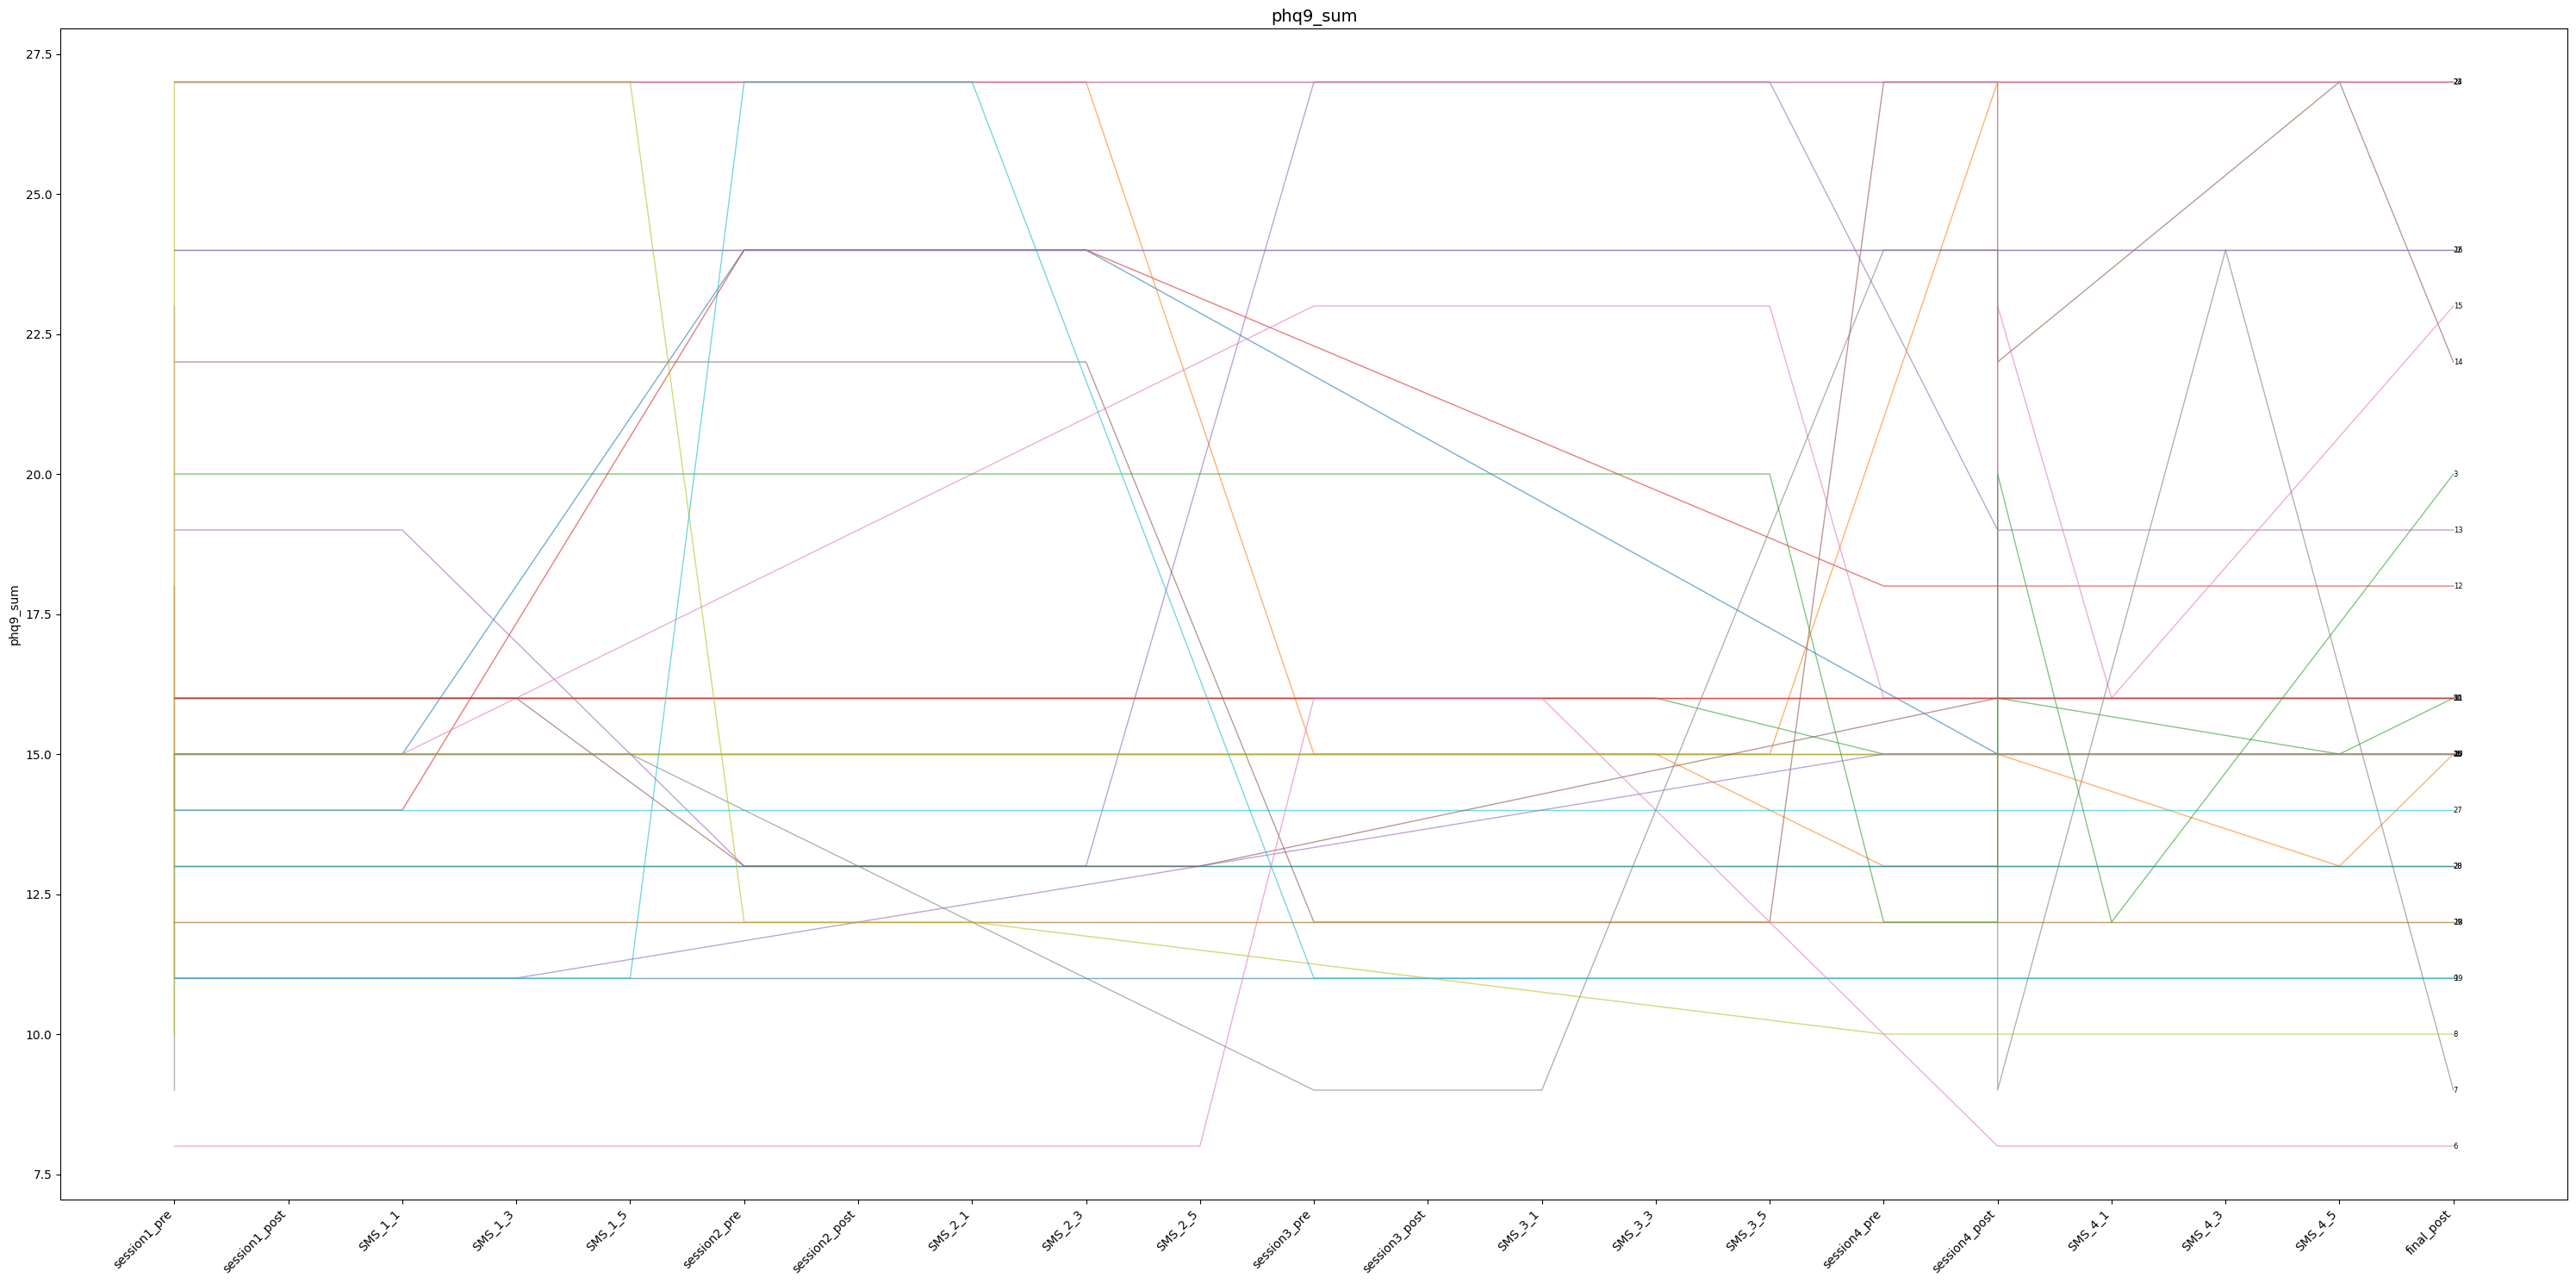

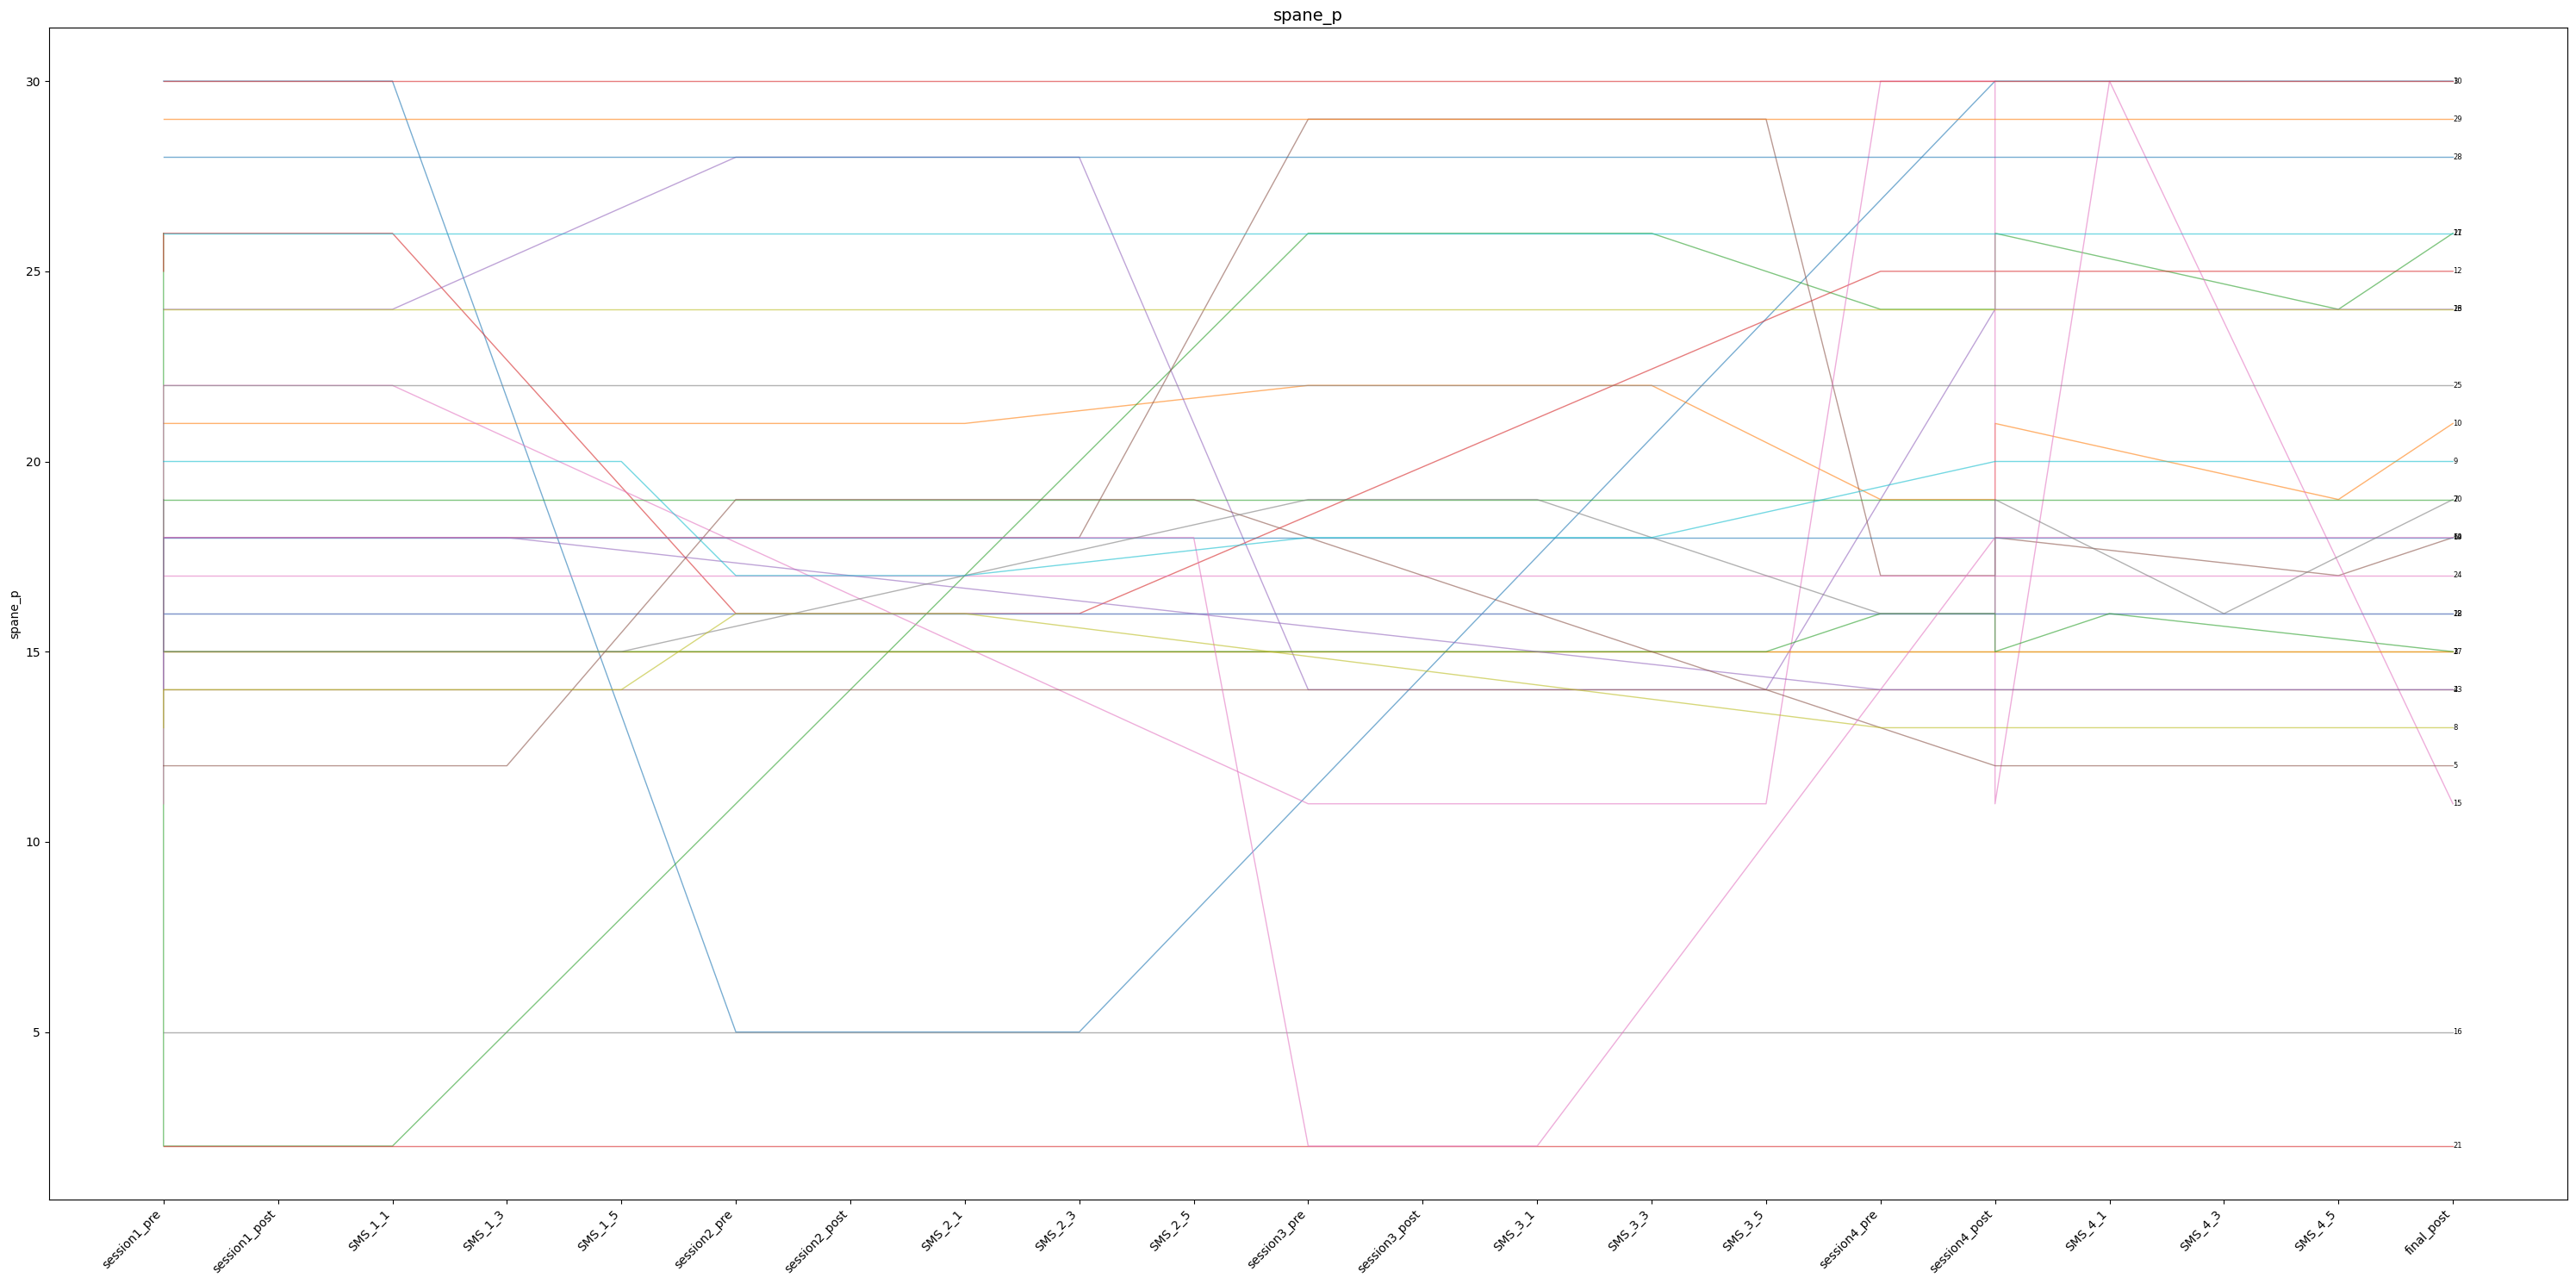

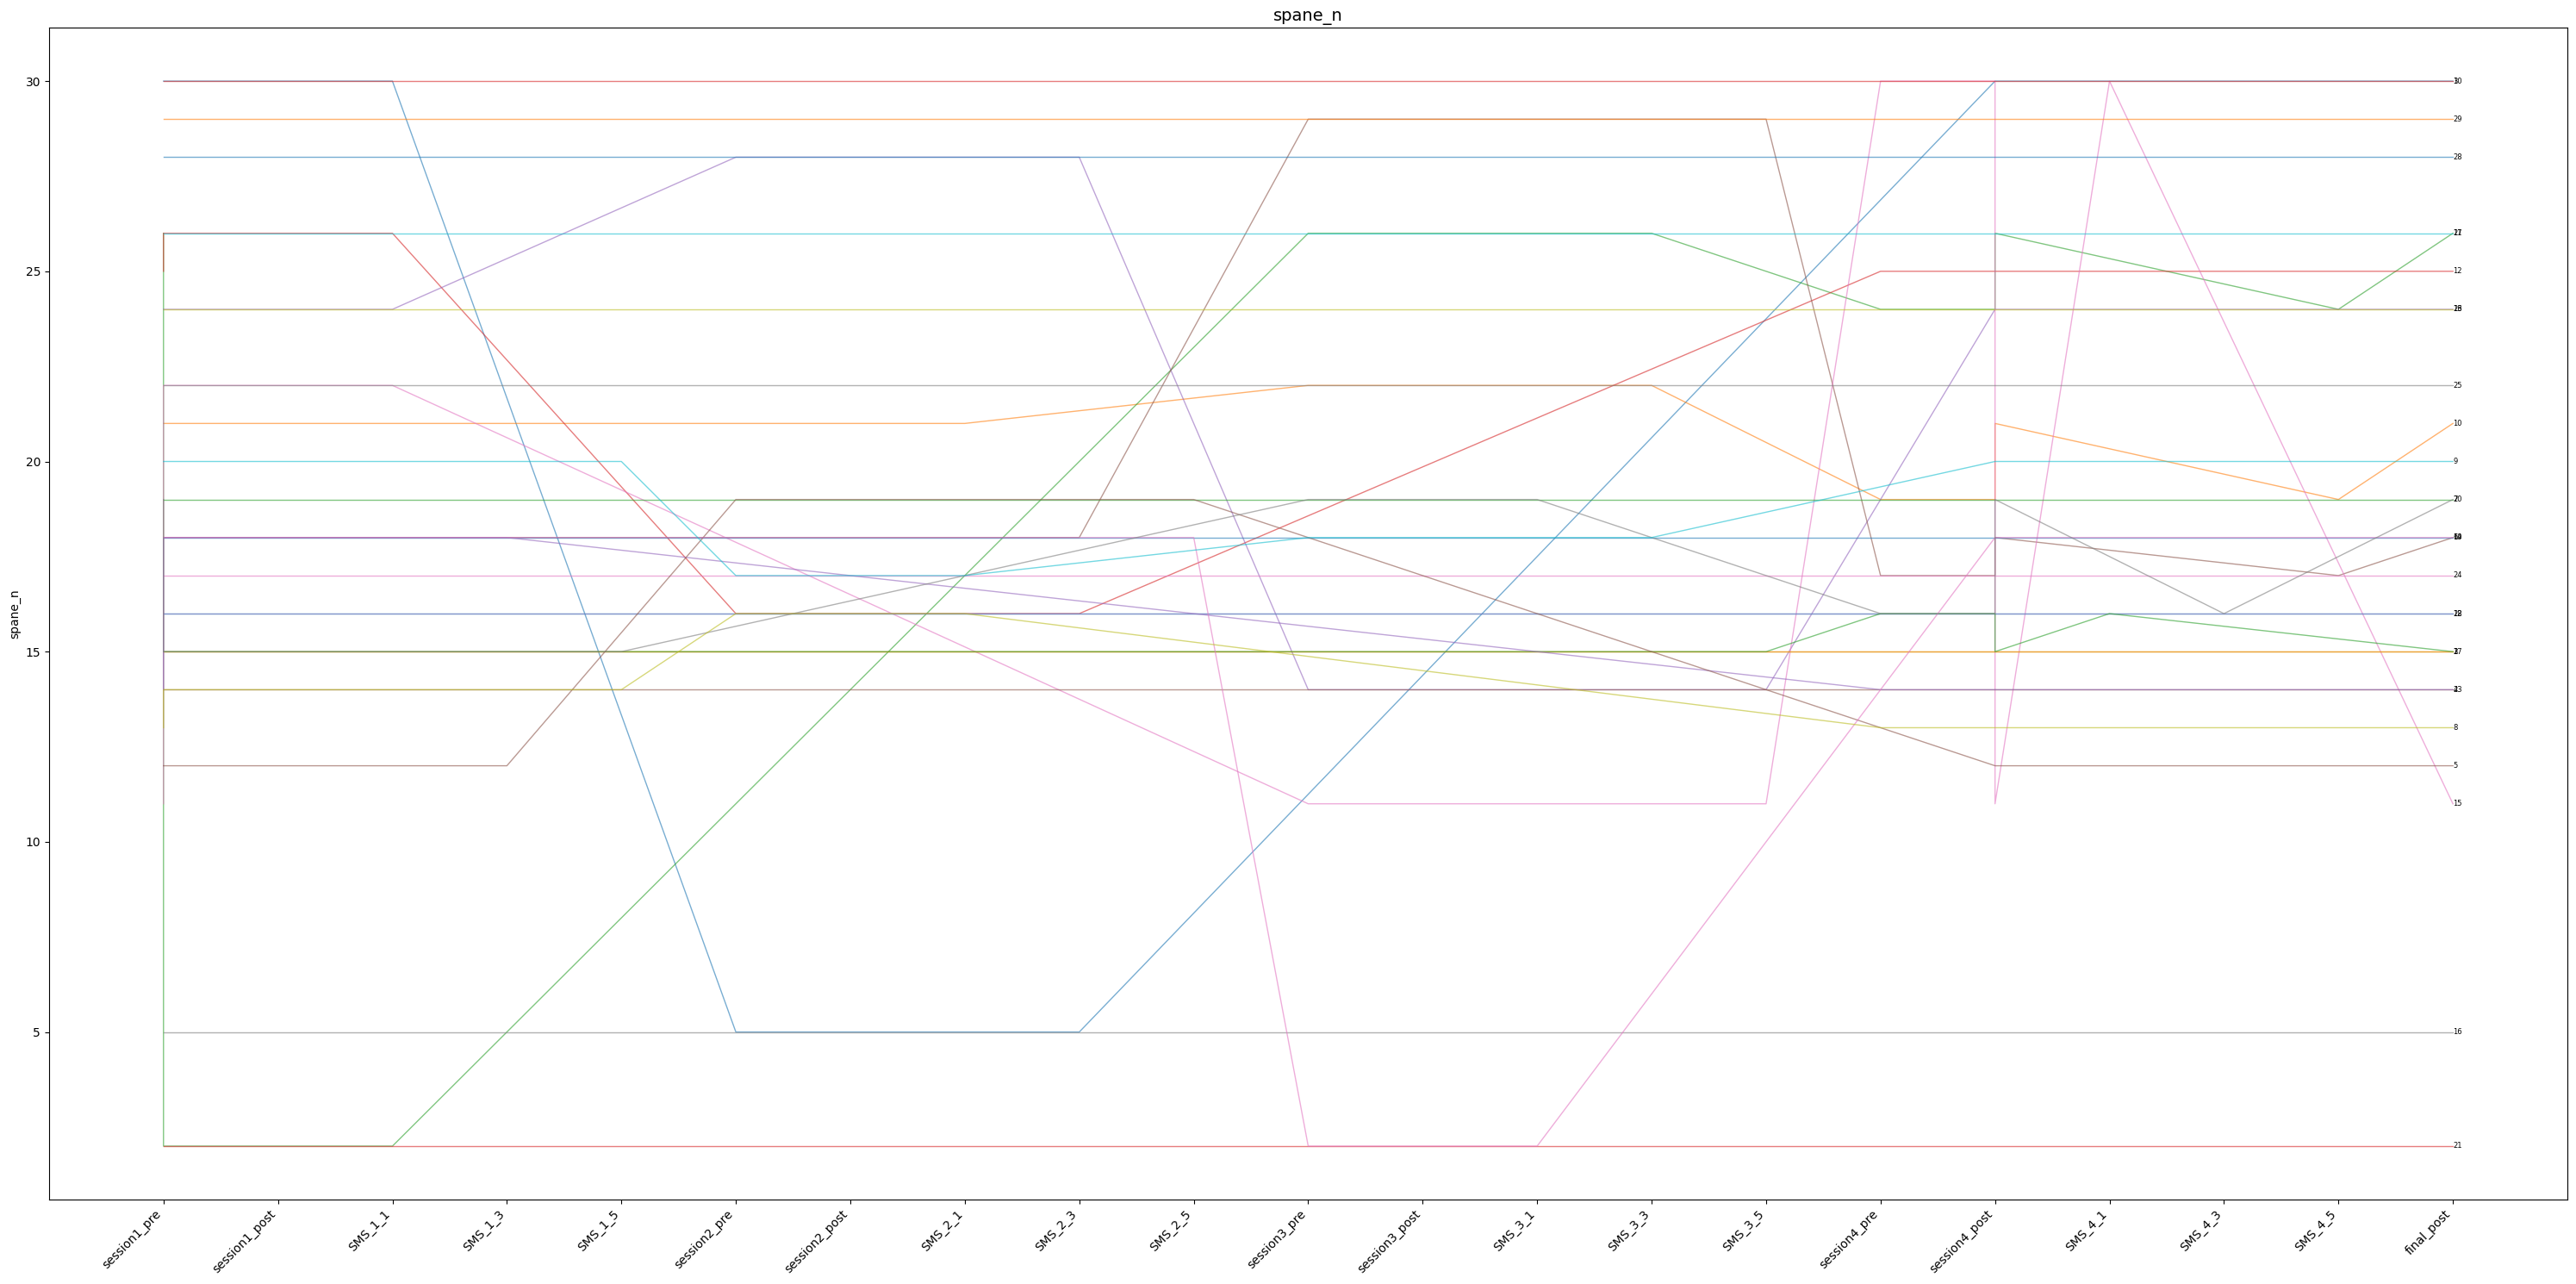

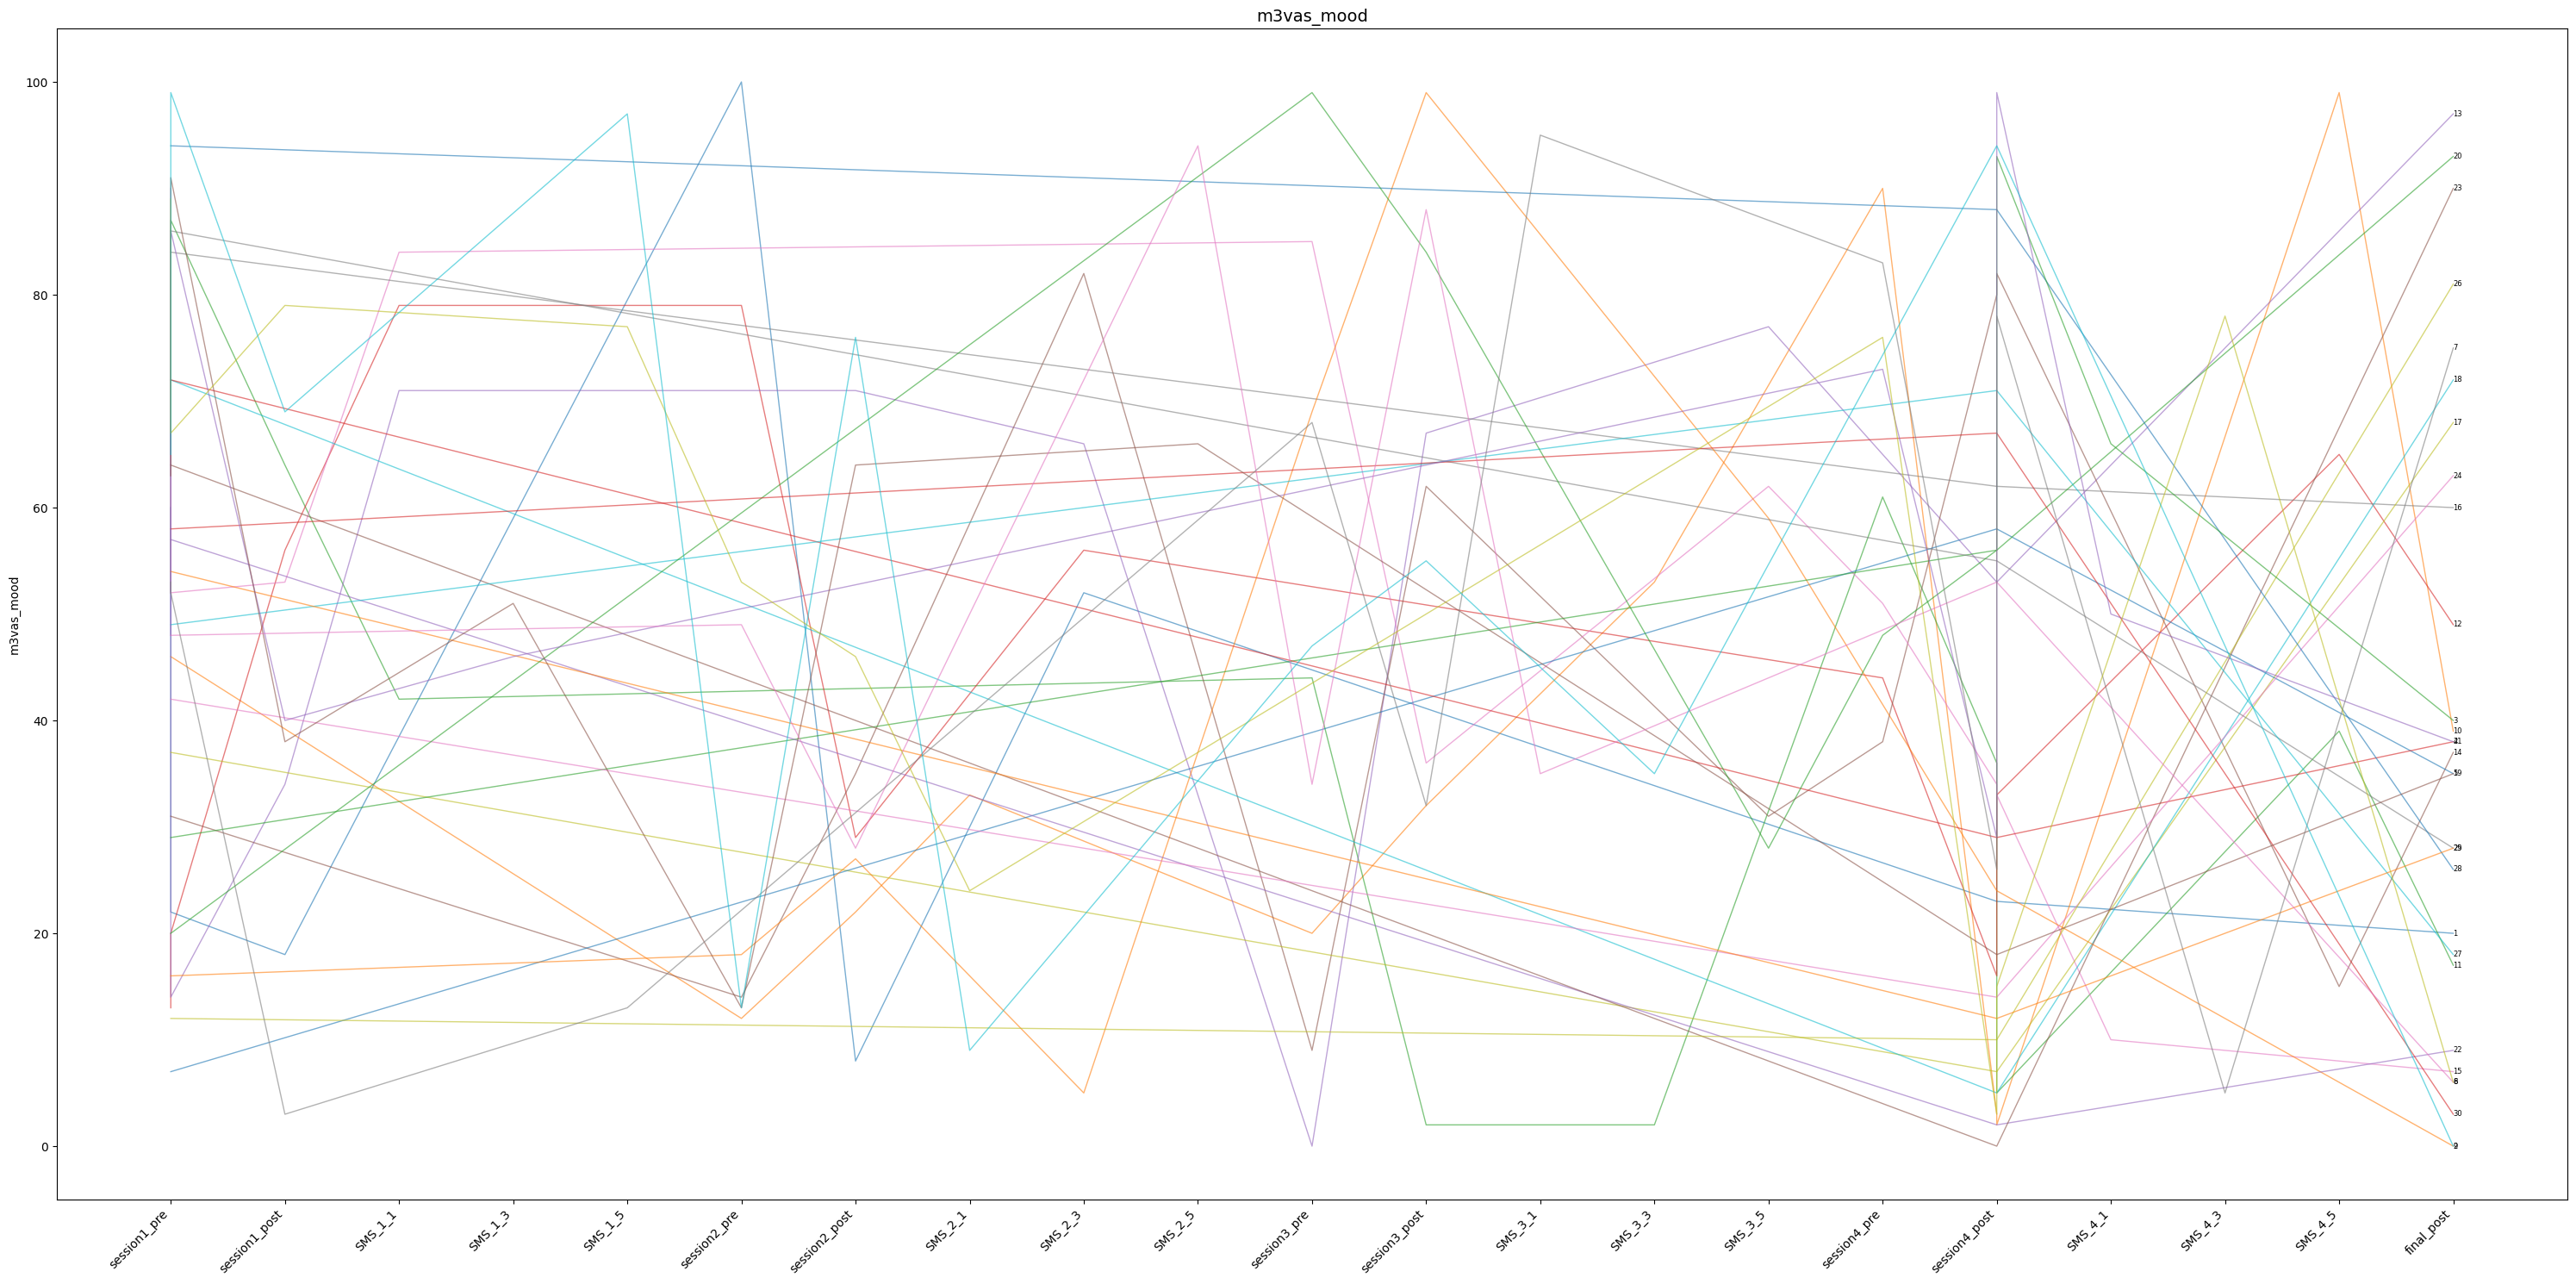

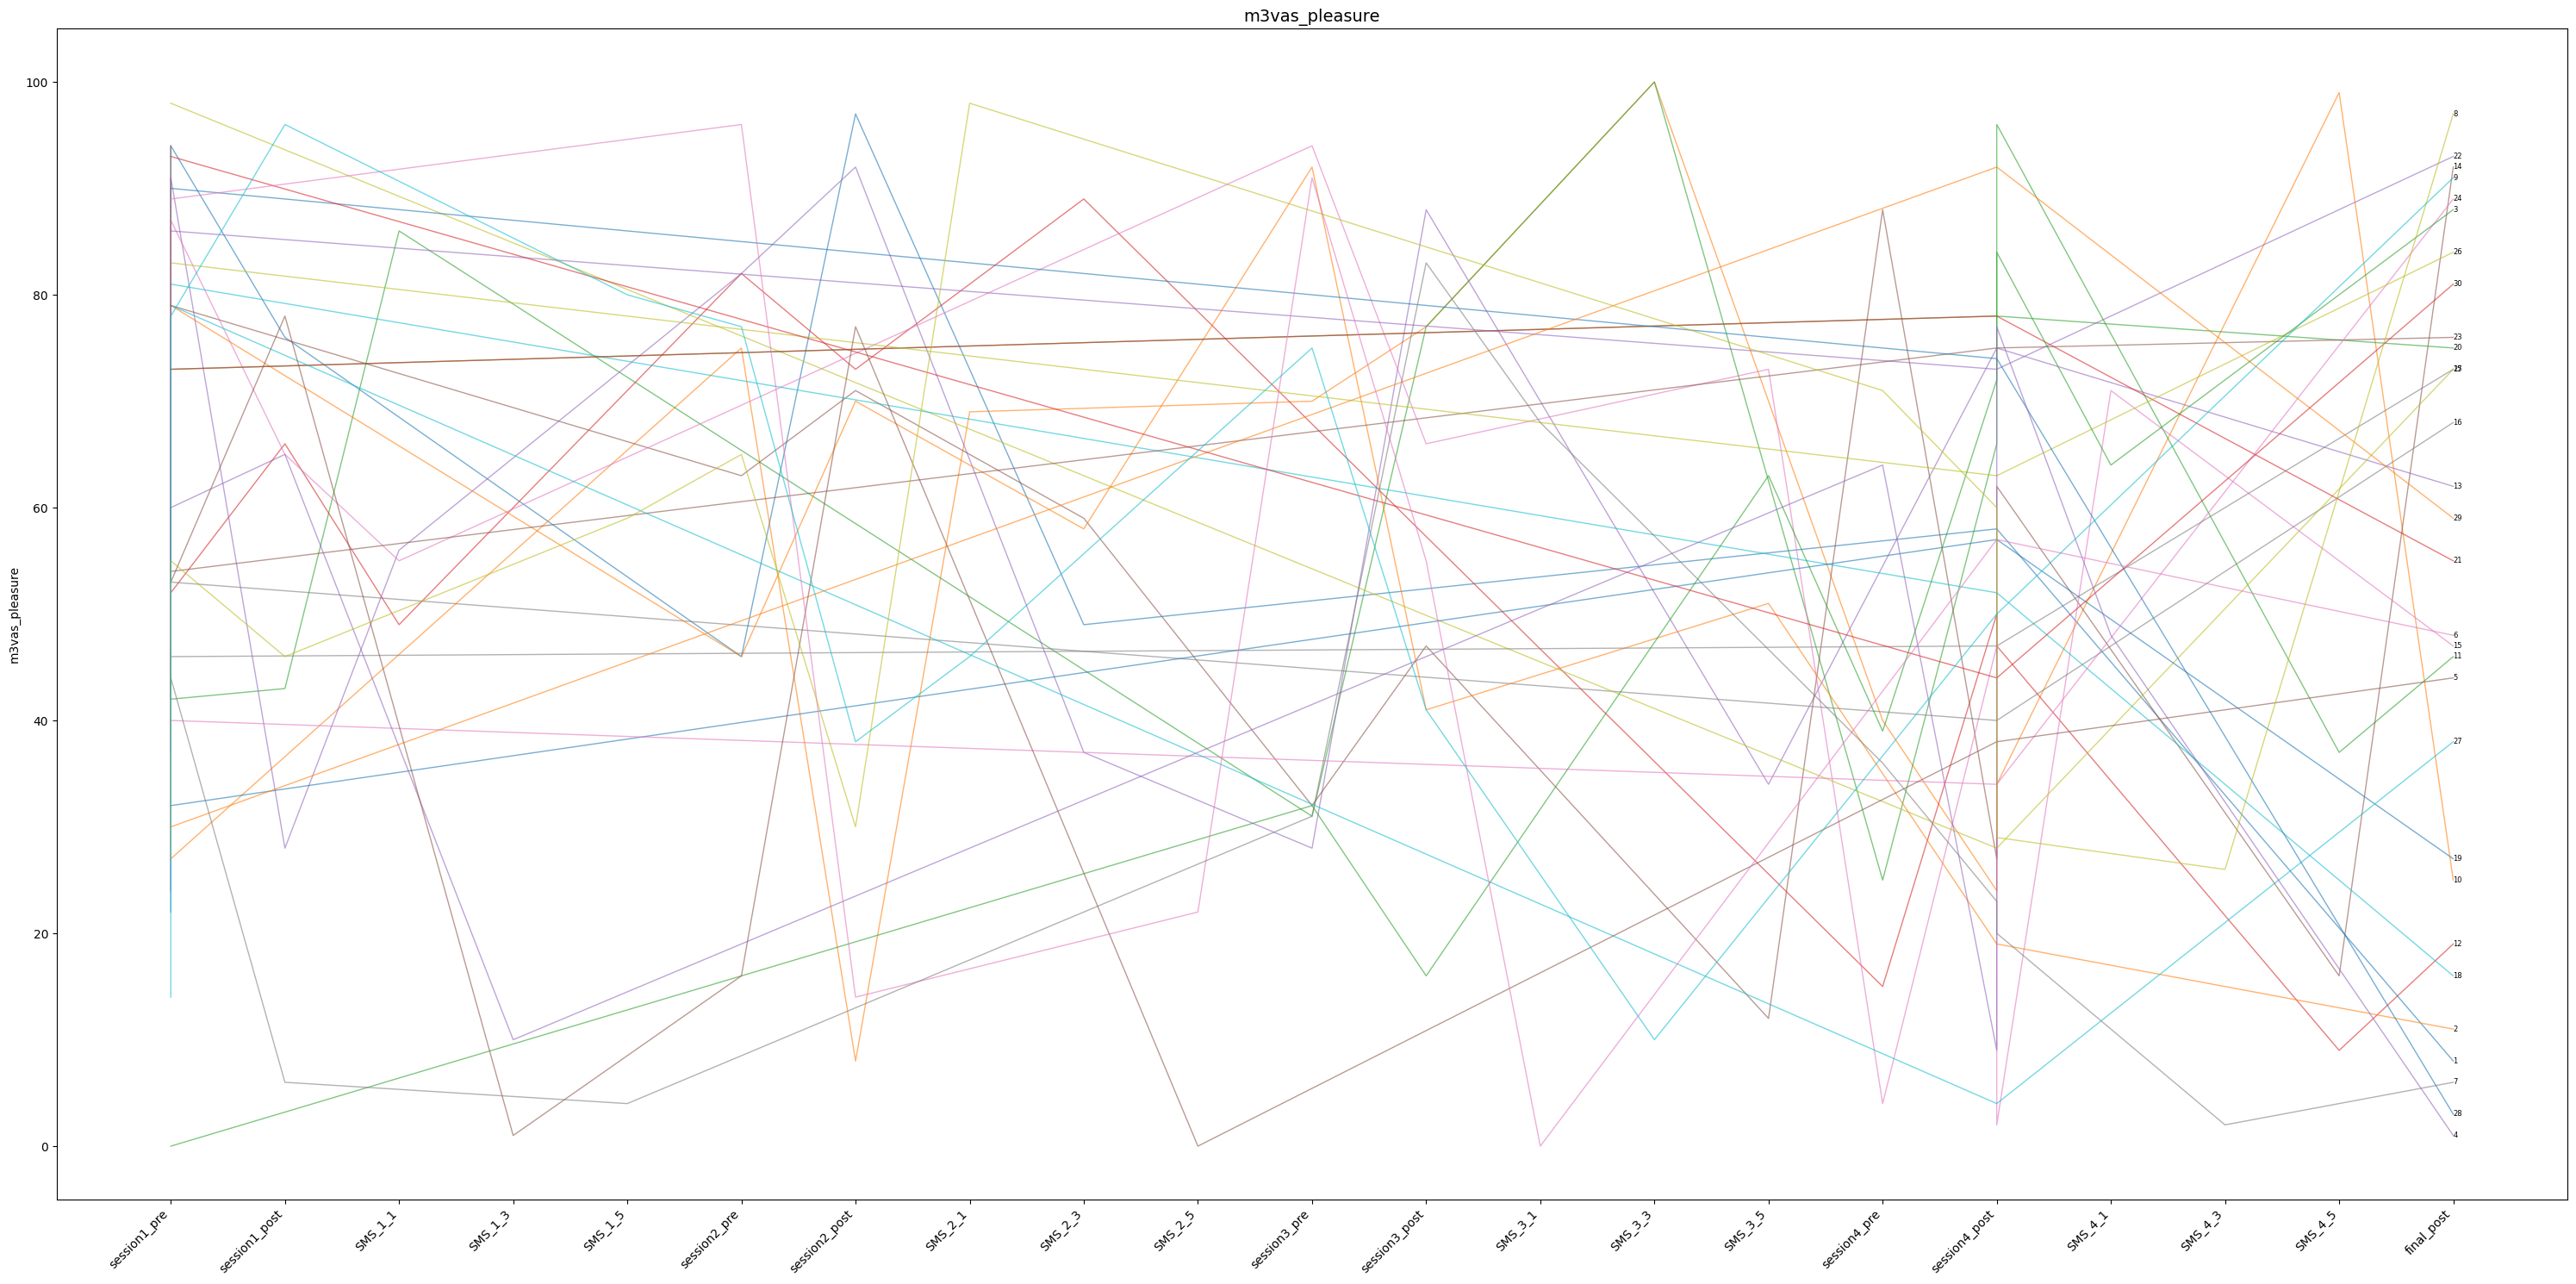

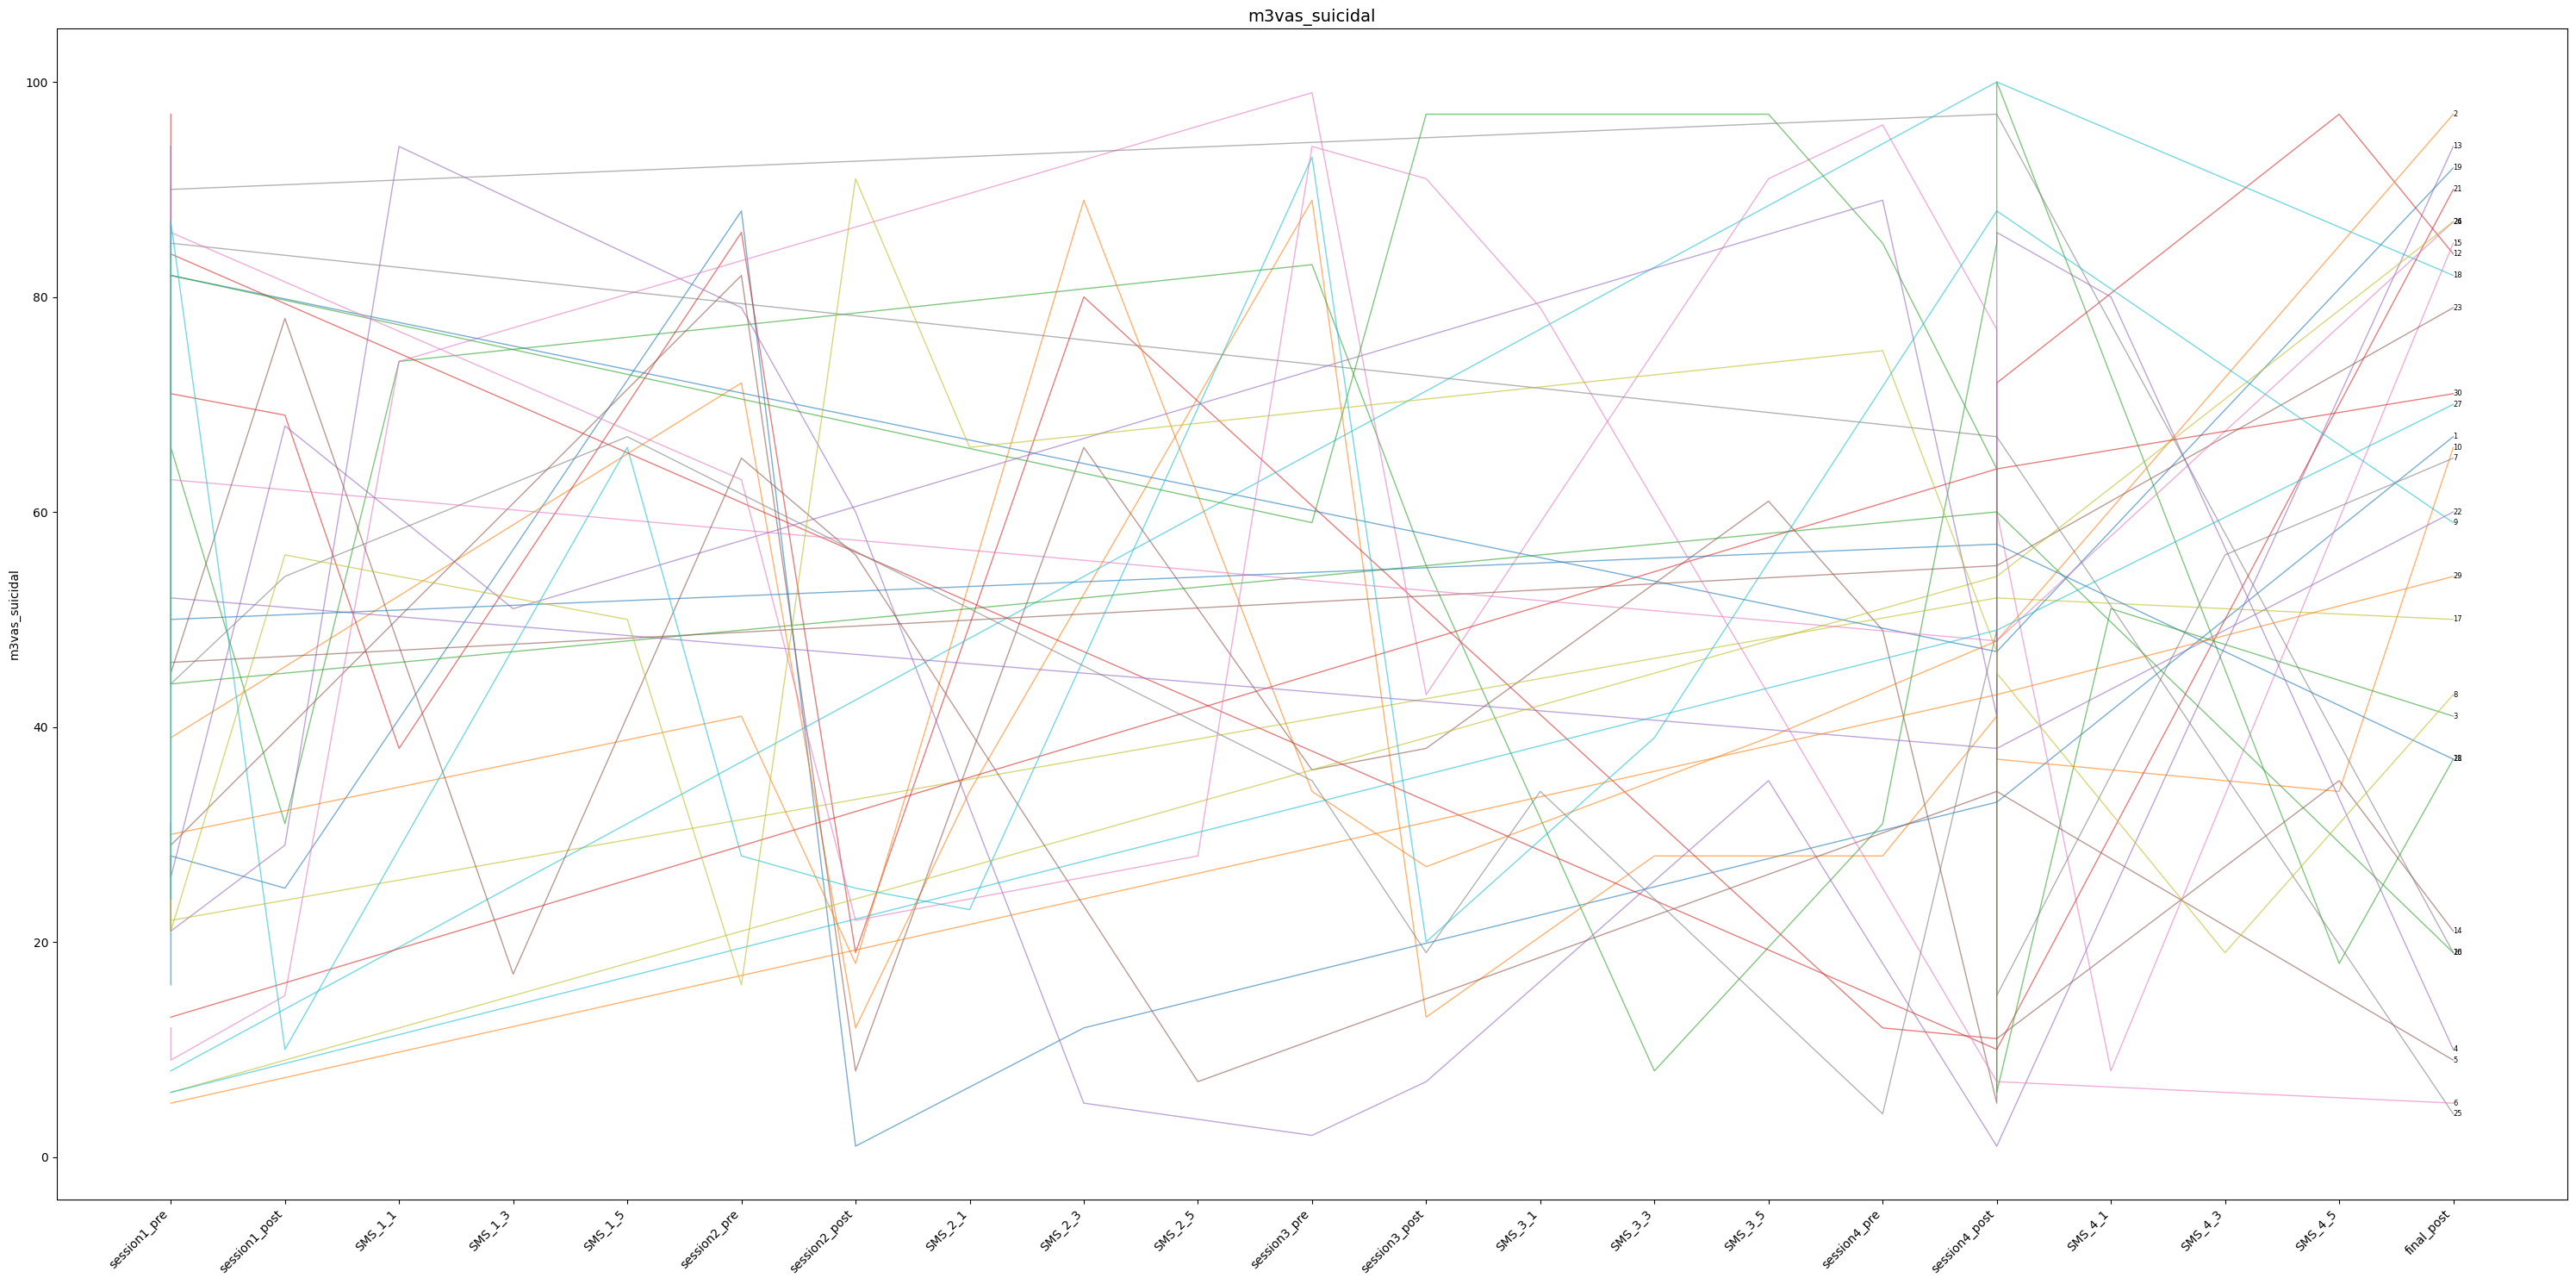

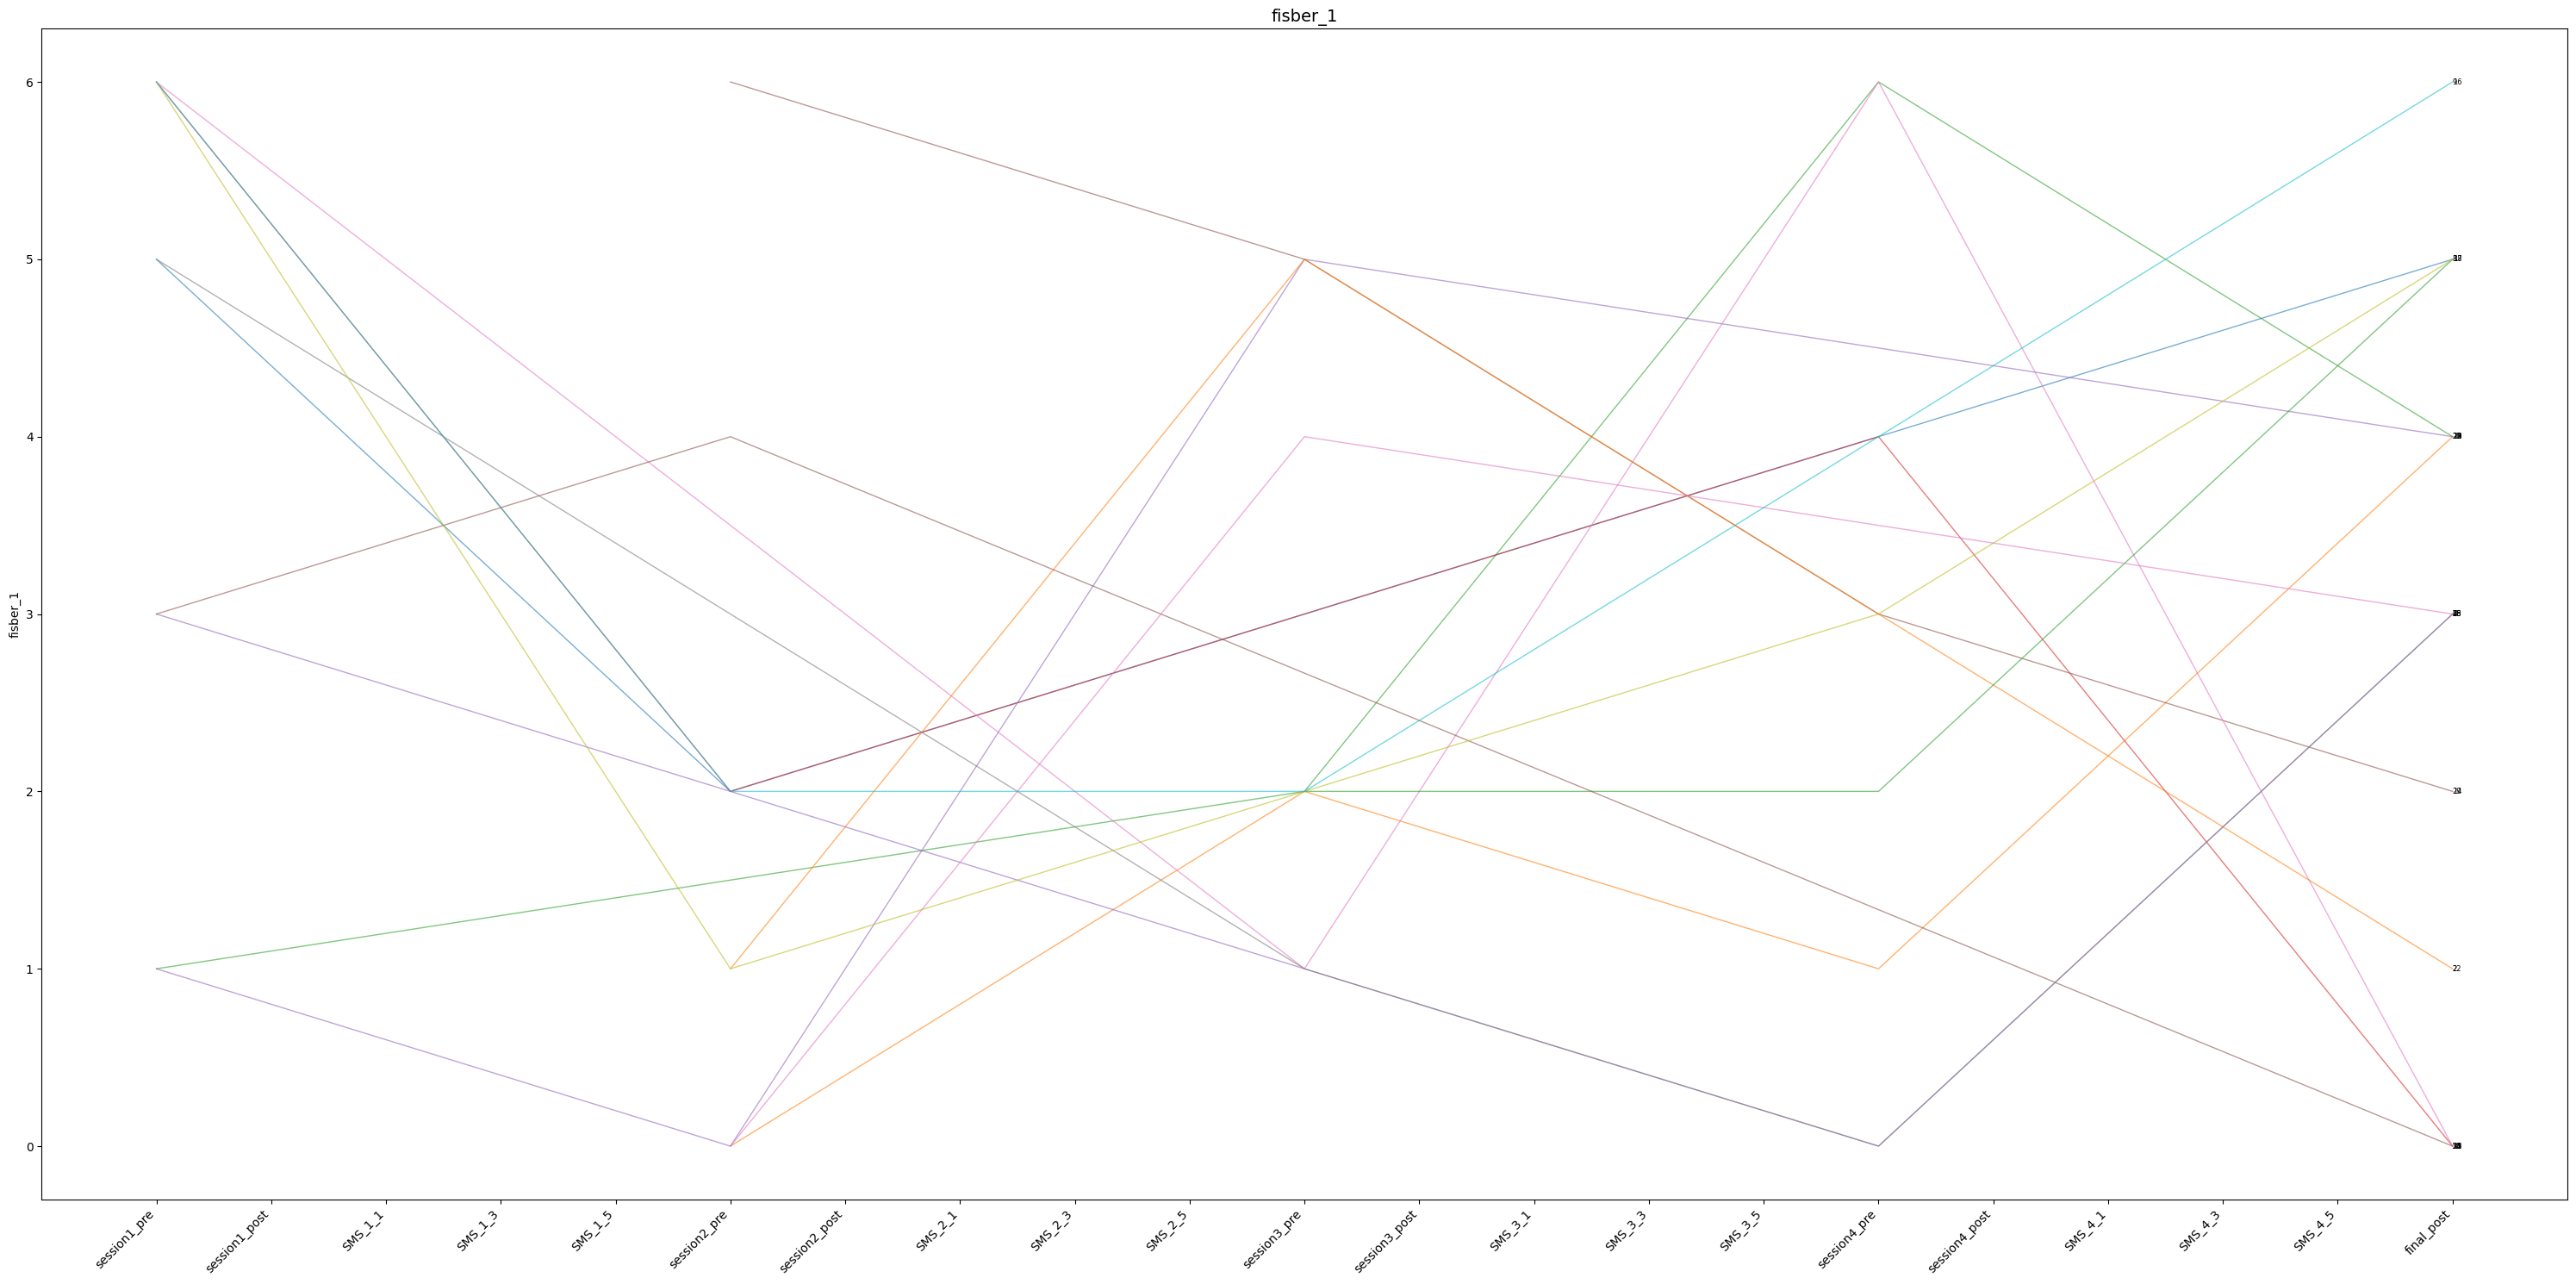

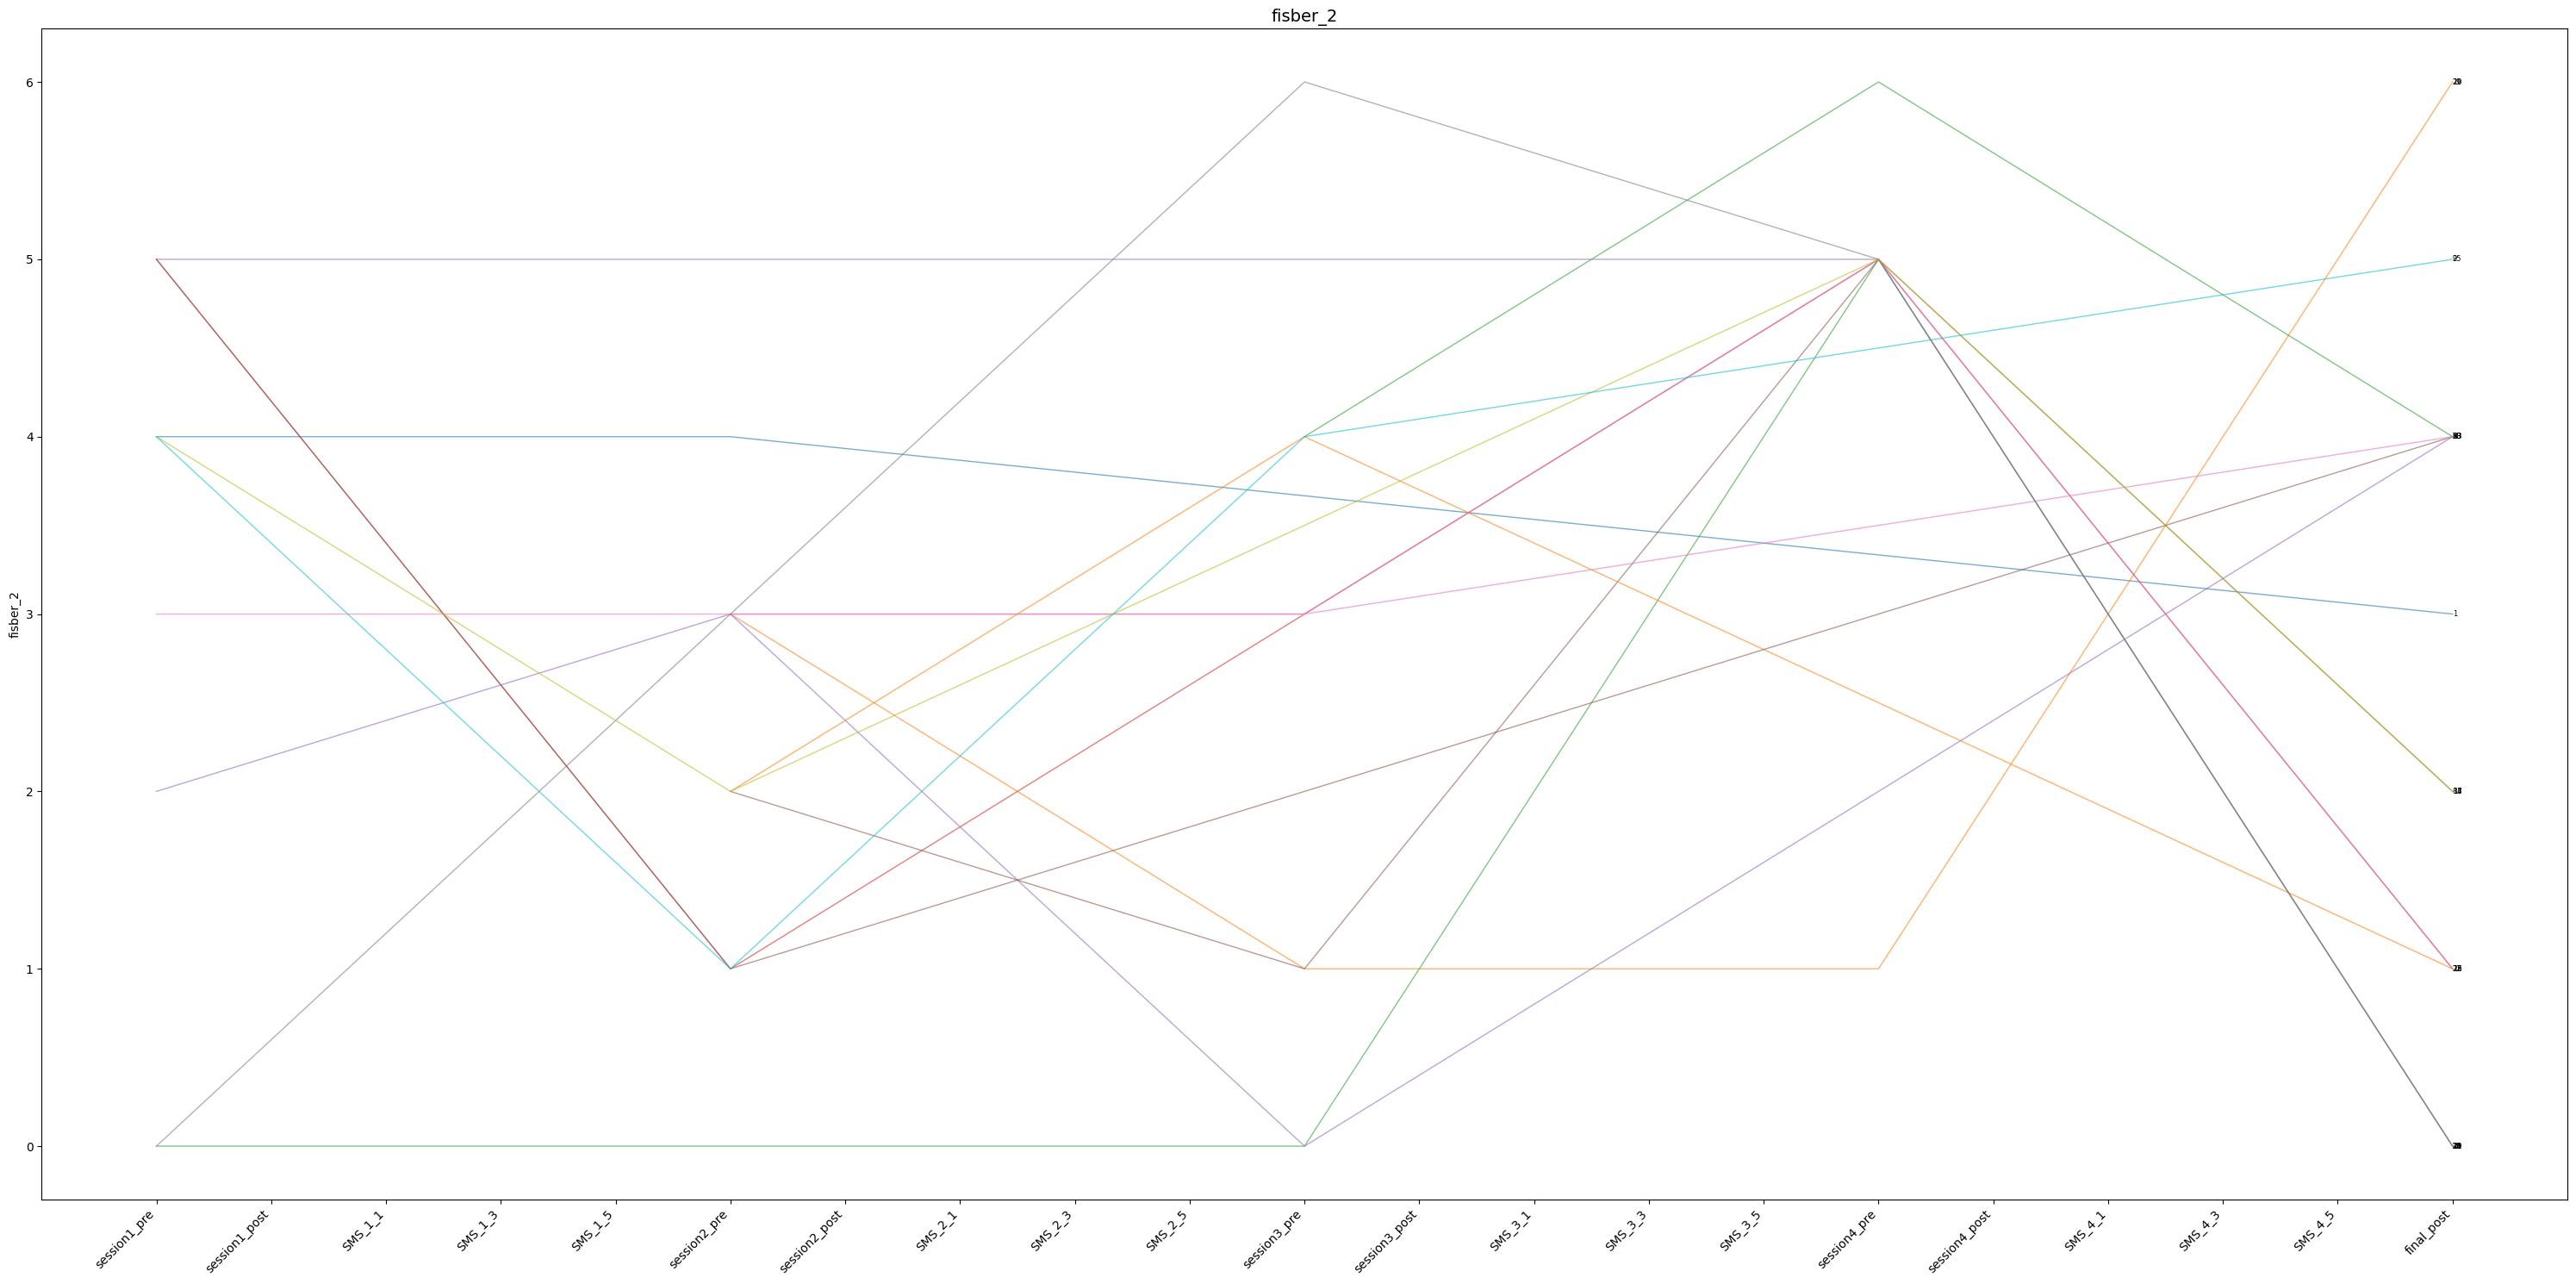

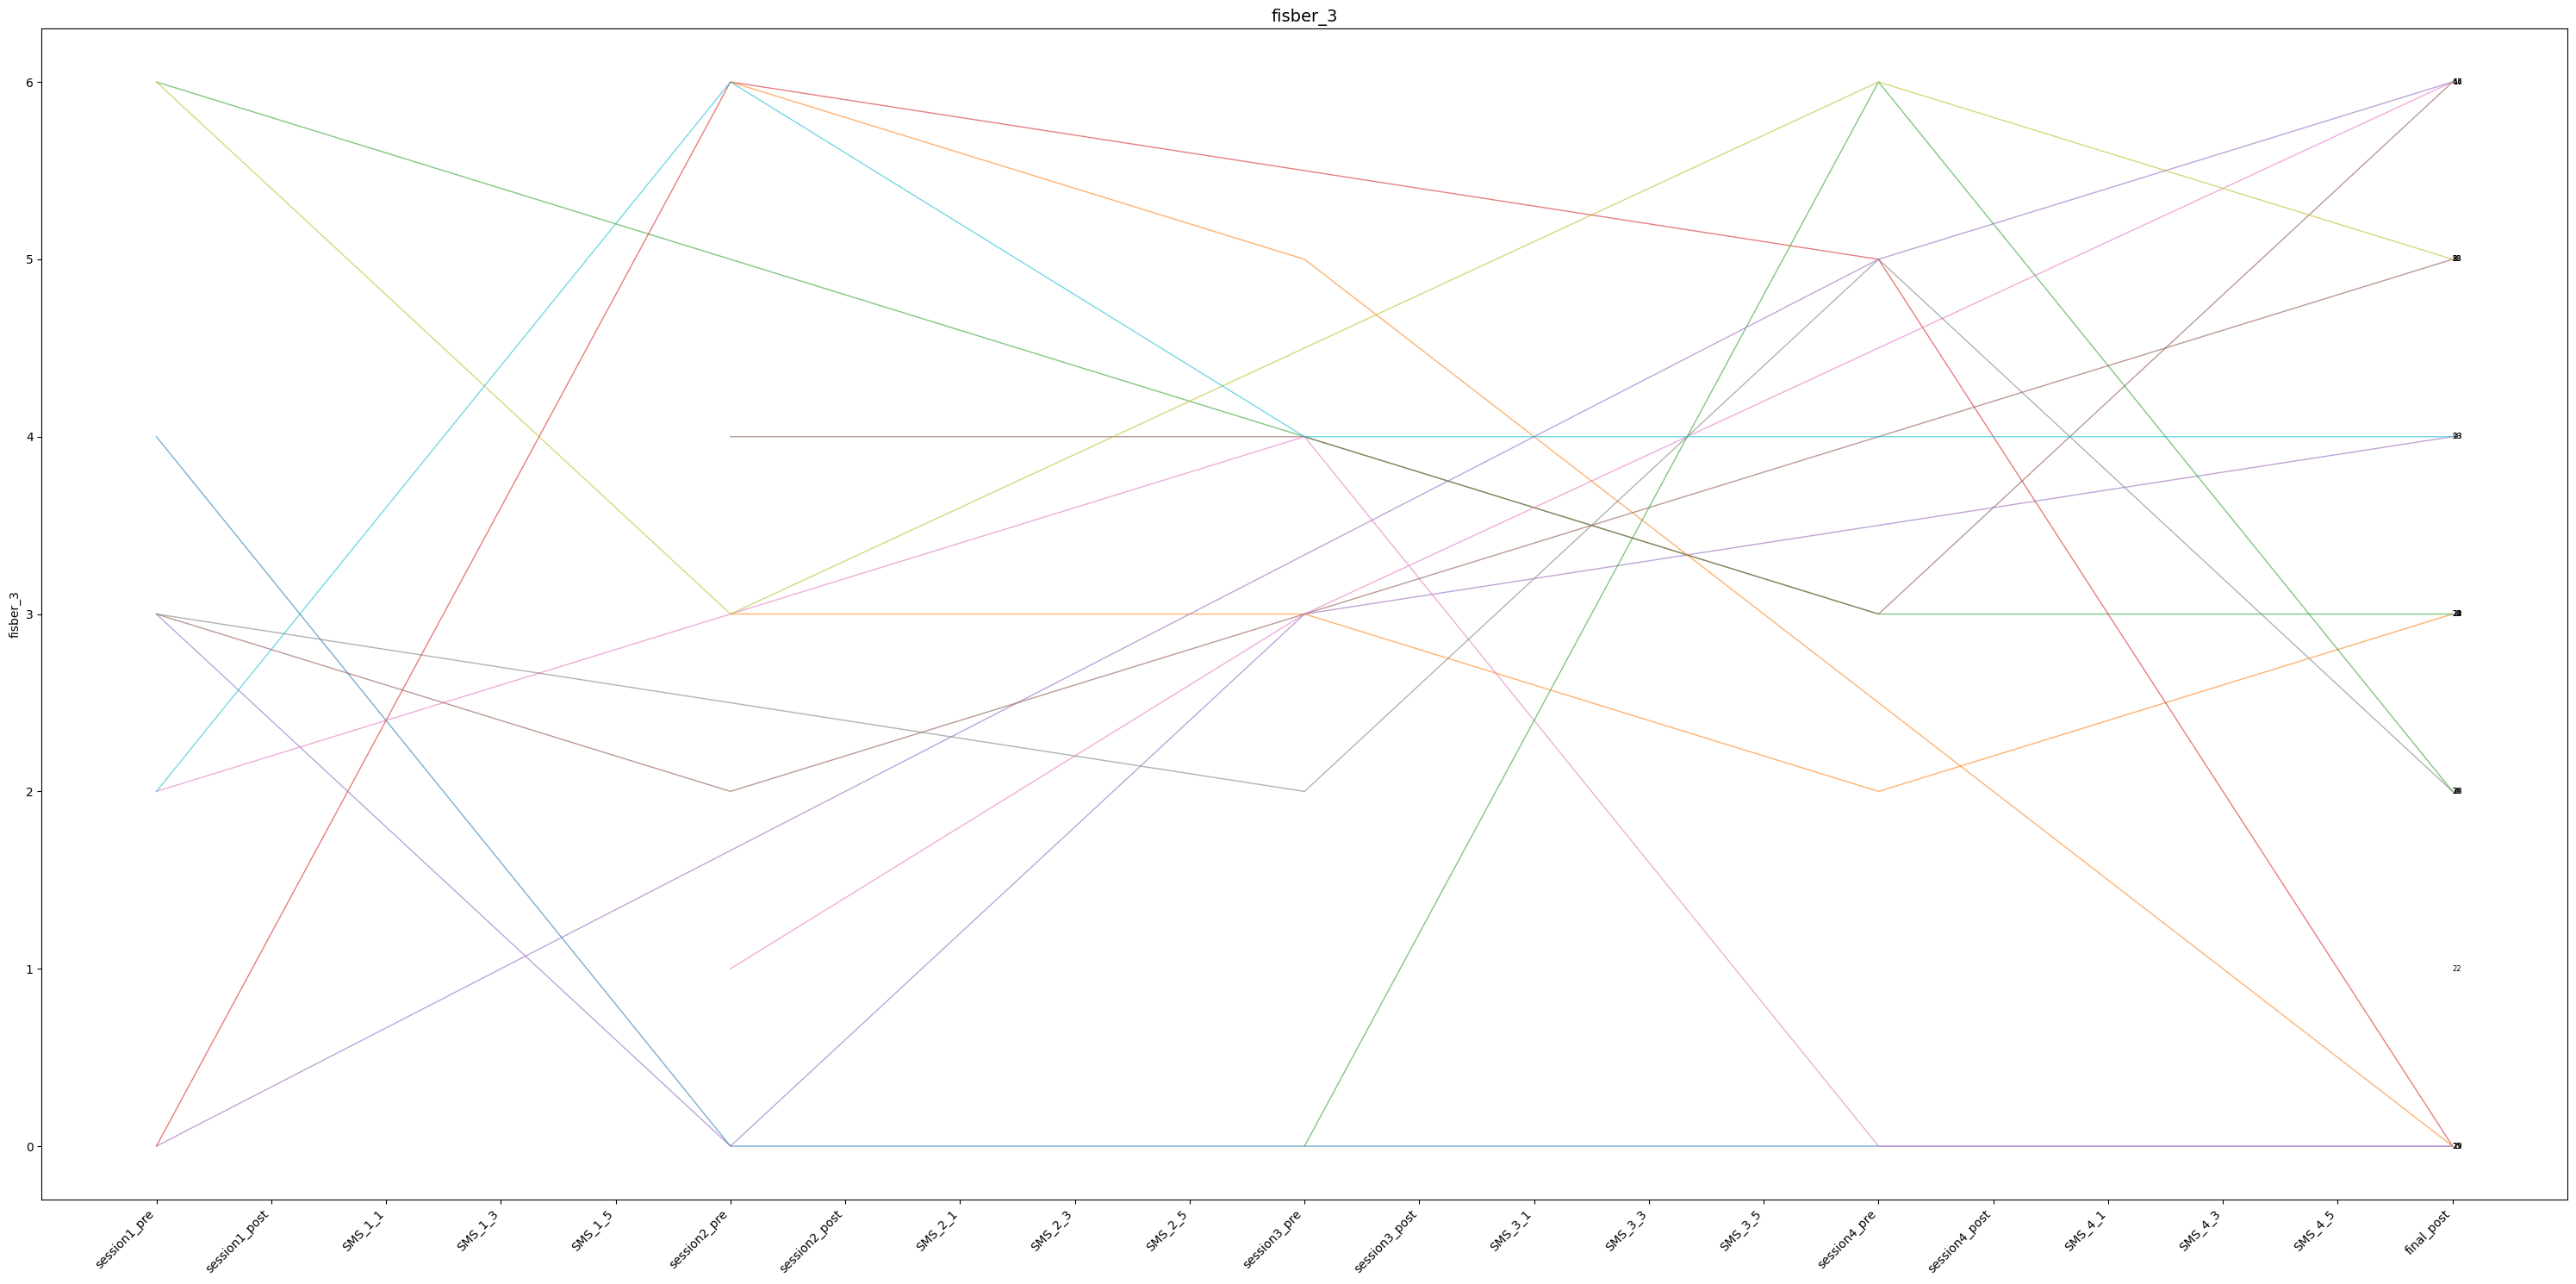

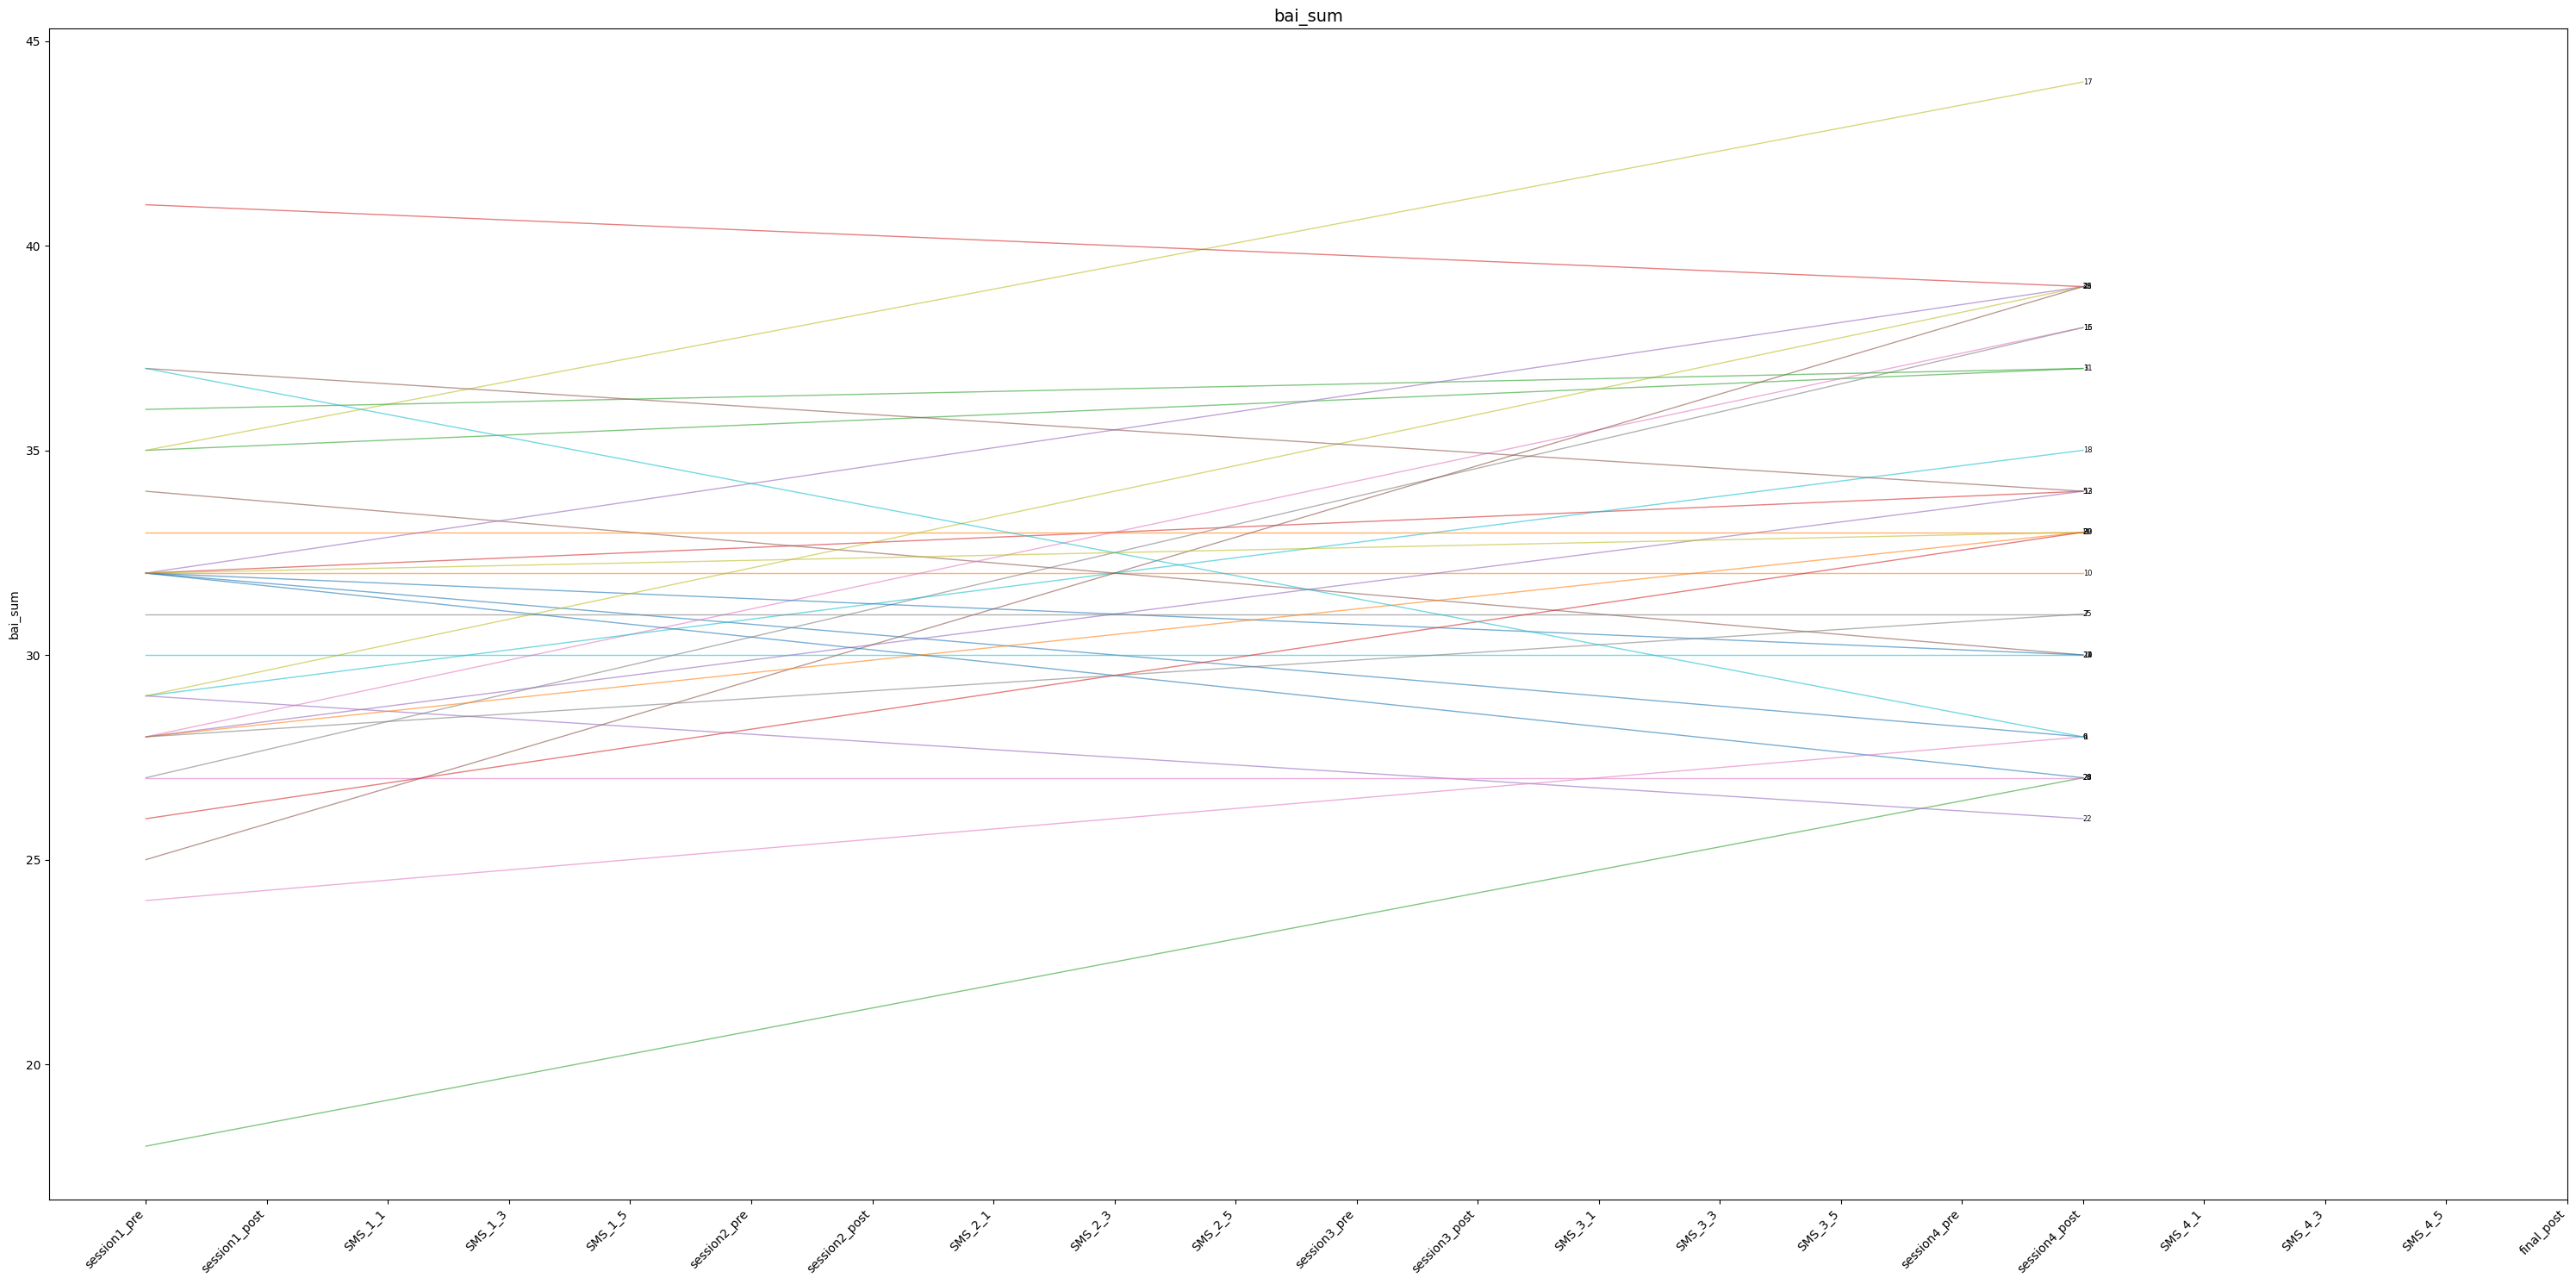

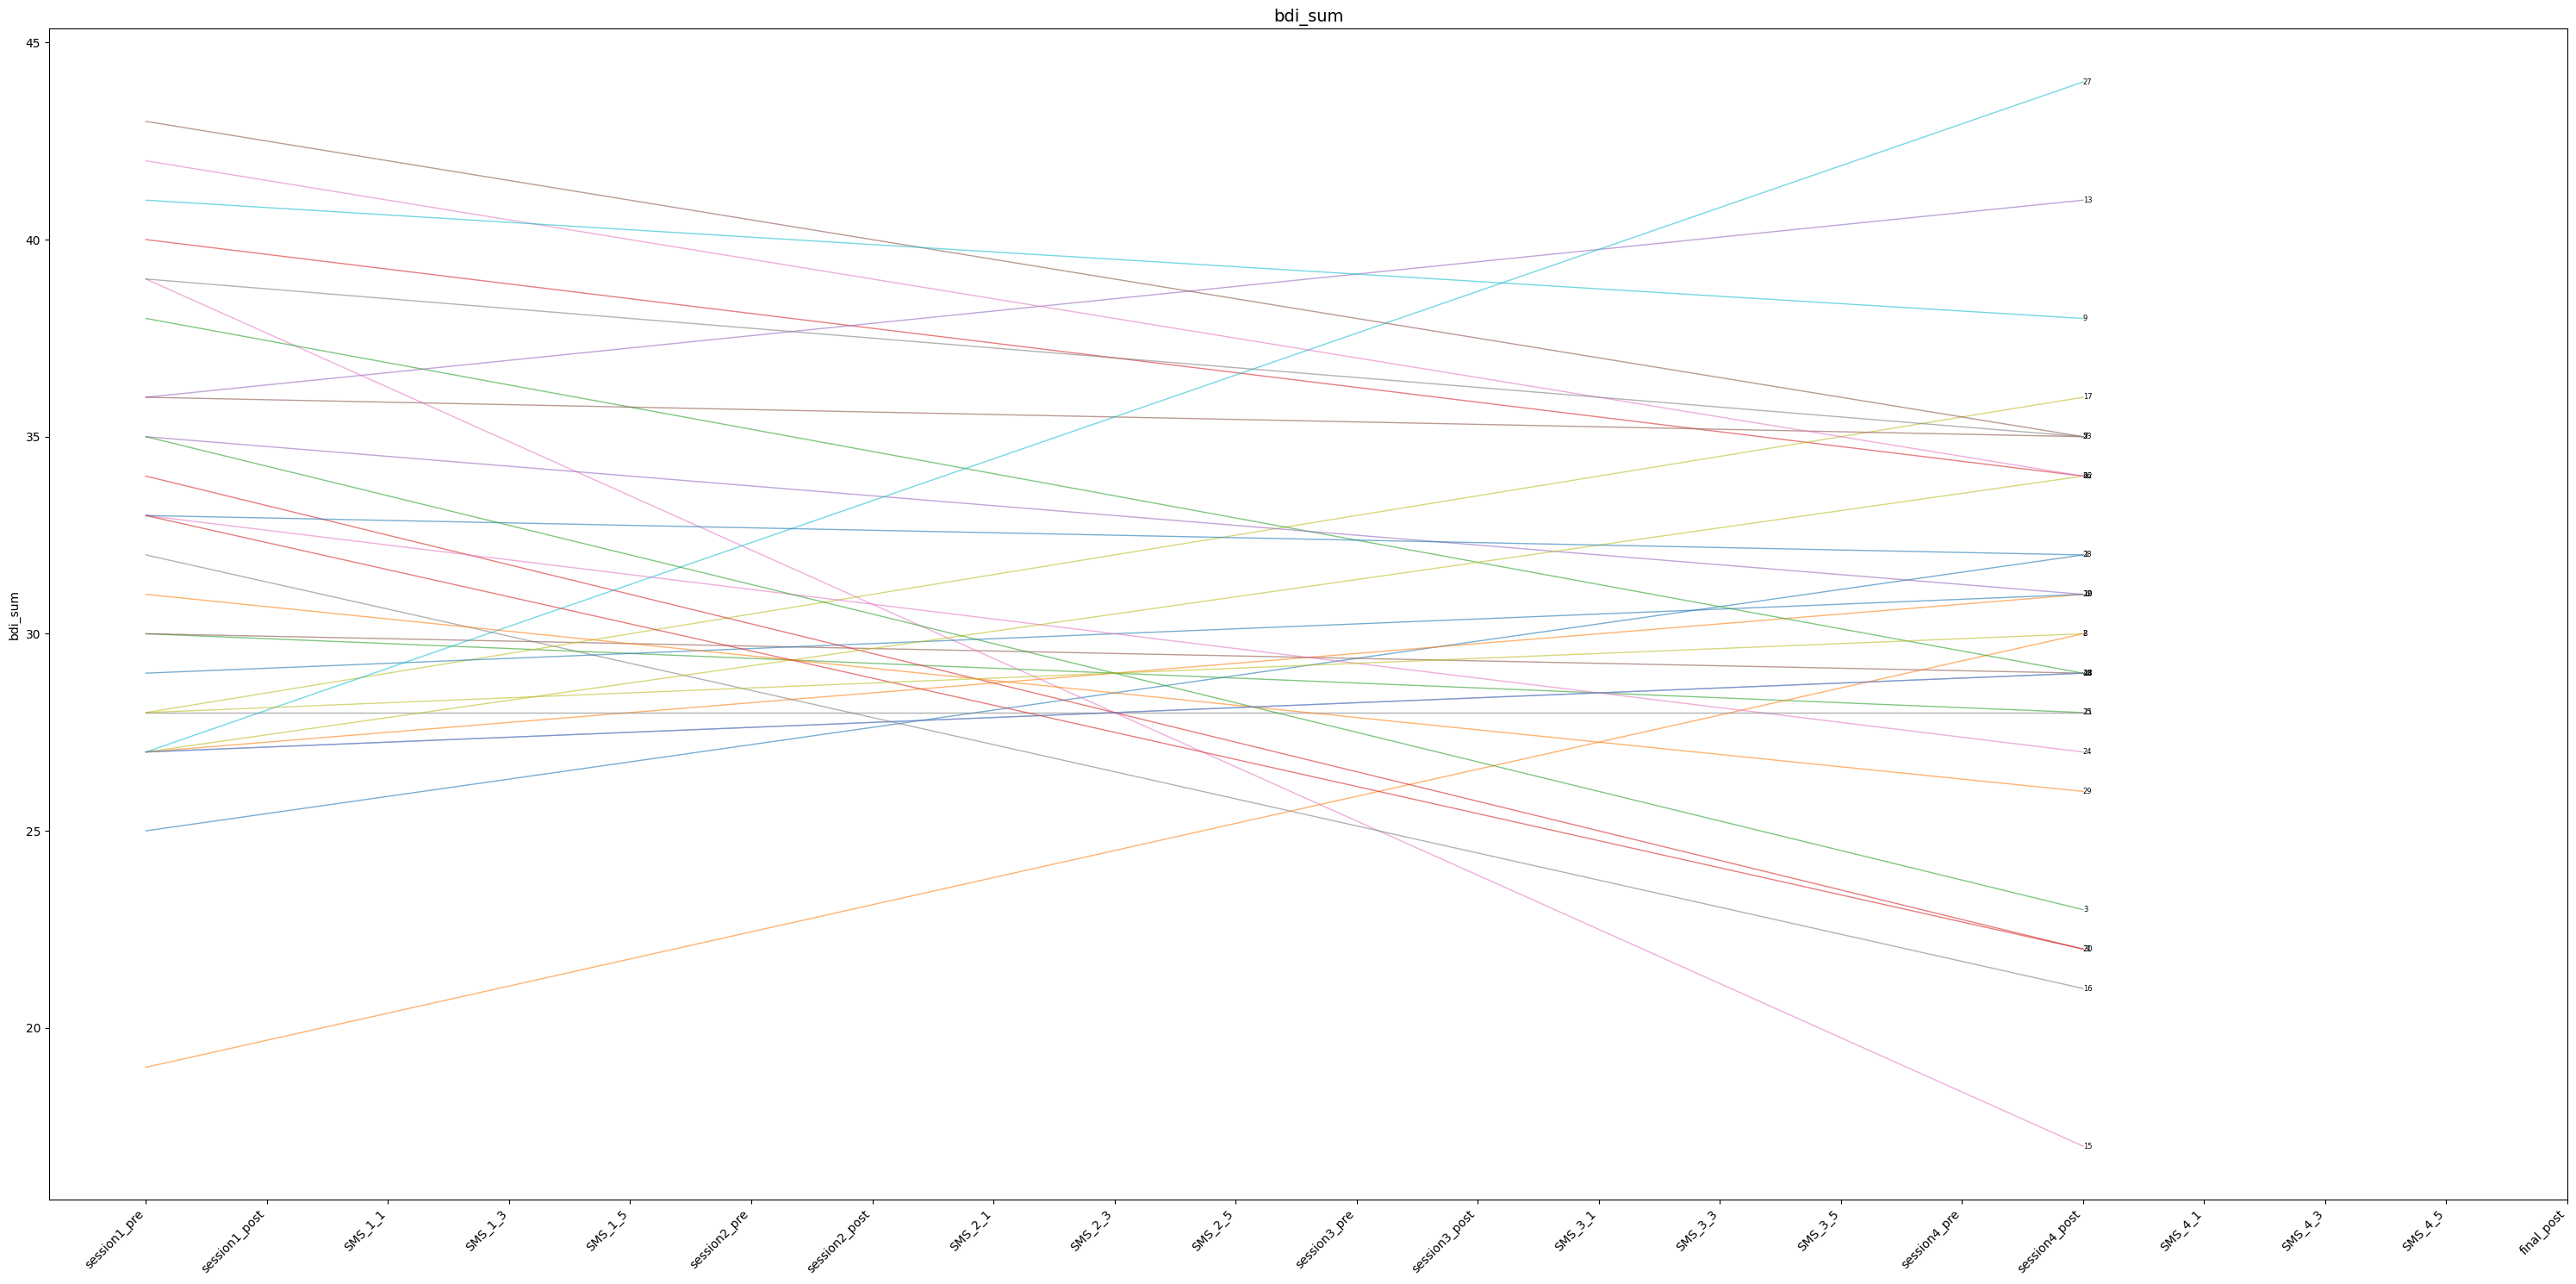

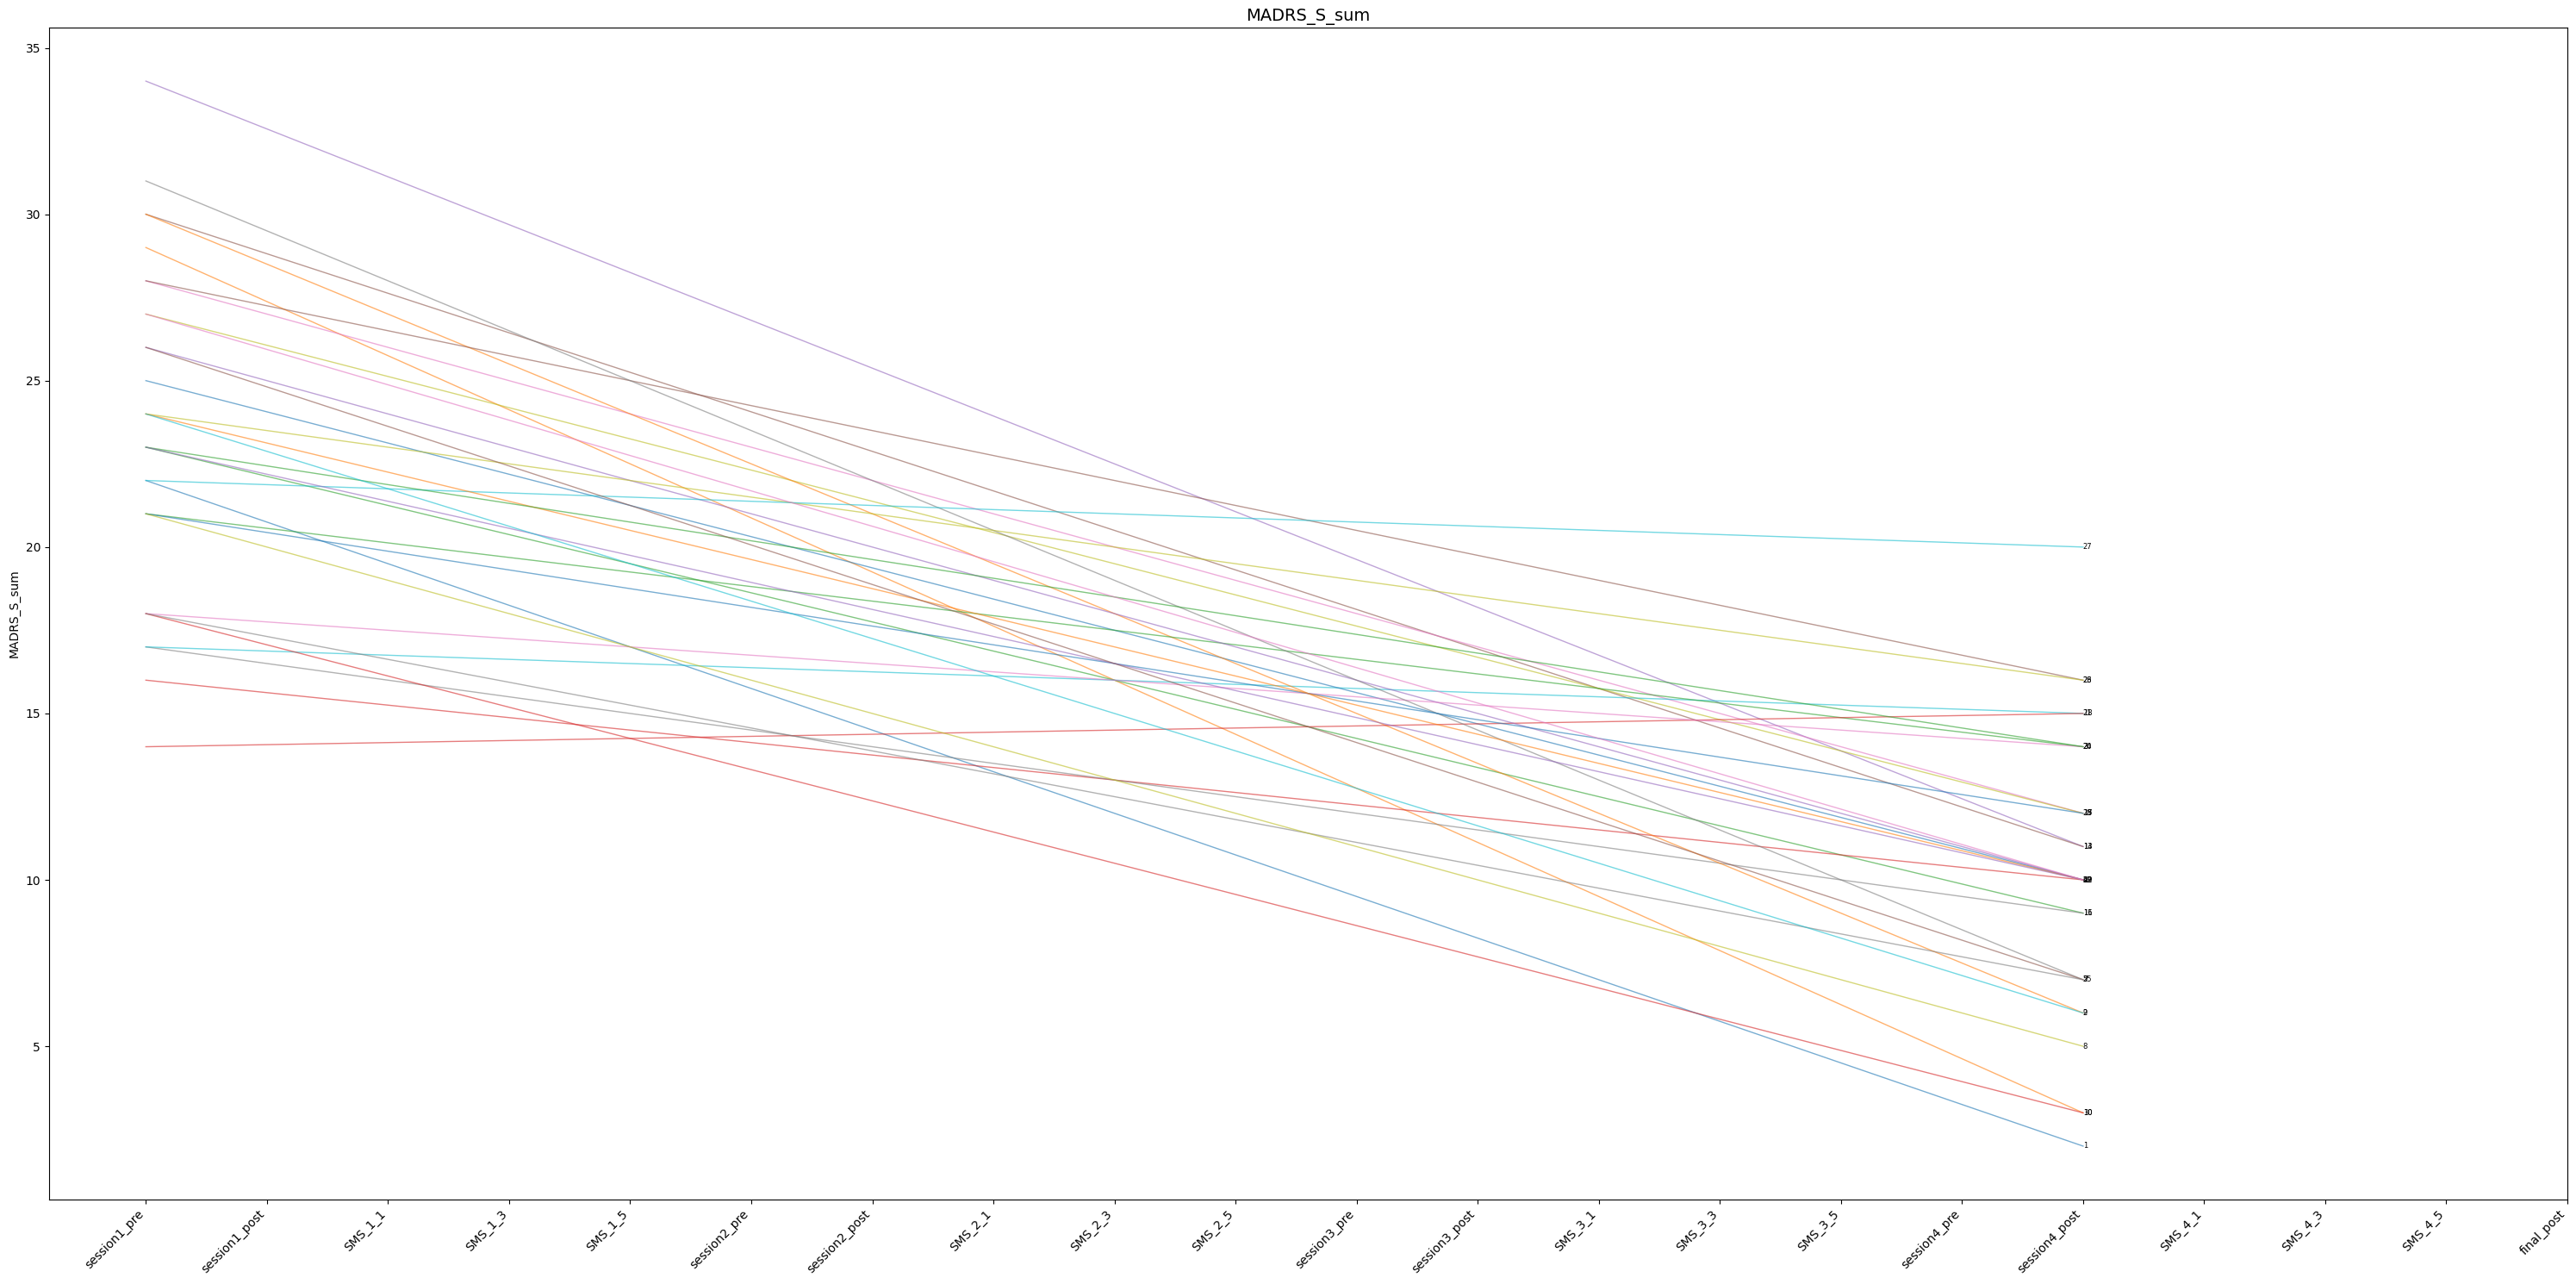

In [26]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from matplotlib.ticker import MaxNLocator

#####
# LOAD
#####
# Directory where your exports live
DATA_DIR = Path('/content')

def find_csv(substring: str) -> Path:
    matches = list(DATA_DIR.glob(f'*{substring}*.csv'))
    if not matches:
        raise FileNotFoundError(f"No file matching ‘{substring}’ in {DATA_DIR}")
    if len(matches) > 1:
        raise ValueError(f"Multiple files match ‘{substring}’: {matches}")
    return matches[0]

def find_csv(substring: str) -> Path:
    matches = list(DATA_DIR.glob(f'*{substring}*.csv'))
    if not matches:
        raise FileNotFoundError(f"No file matching ‘{substring}’ in {DATA_DIR}")
    if len(matches) > 1:
        raise ValueError(f"Multiple files match ‘{substring}’: {matches}")
    return matches[0]

df_s1_pre     = pd.read_csv(find_csv('pre_session_1'),     dtype=str)
df_s2to4_pre  = pd.read_csv(find_csv('pre_sessions_2-4'),  dtype=str)
df_s2to4_post = pd.read_csv(find_csv('post_sessions_1-3'), dtype=str)
df_s4_post    = pd.read_csv(find_csv('post_session_4'),    dtype=str)
df_sms        = pd.read_csv(find_csv('sms_day1,3,5'),      dtype=str)
df_final      = pd.read_csv(find_csv('sms_post'),          dtype=str)

all_dfs = [df_s1_pre, df_s2to4_pre, df_s2to4_post, df_s4_post, df_sms, df_final]

#####
# 1b) CLEAN BDI ITEMS (extract the leading number, not trailing)
#####
import re

for df in all_dfs:
    # find any bdi_# or bdi_#_1 column
    bdi_raw = [c for c in df.columns if re.fullmatch(r"bdi_\d+(?:_1)?", c)]
    for col in bdi_raw:
        # pull off the first group of digits, then cast to float
        df[col] = (
            df[col]
              .astype(str)
              .str.extract(r'^(\d+)')[0]
              .astype(float)
        )

#####
# helper to sum scales
#####
def sum_scale(df, cols, new_col):
    df[cols] = df[cols].apply(pd.to_numeric, errors='coerce')
    df[new_col] = df[cols].sum(axis=1)

def get_scale_cols(df, prefix, count, allow_suffix=False):
    cols = []
    for i in range(1, count+1):
        main = f"{prefix}_{i}"
        alt  = f"{prefix}_{i}_1"
        if main in df.columns:
            cols.append(main)
        elif allow_suffix and alt in df.columns:
            cols.append(alt)
    return cols

#####
# 2) COMPUTE SCALE TOTALS (where present)
#####
for df in all_dfs:
    # BAI
    bai_cols = get_scale_cols(df, 'bai', 21)
    if bai_cols:
        sum_scale(df, bai_cols, 'bai_sum')
    # BDI
    bdi_cols = get_scale_cols(df, 'bdi', 21)
    if bdi_cols:
        sum_scale(df, bdi_cols, 'bdi_sum')
    # MADRS (mards variants)
    mards_cols = get_scale_cols(df, 'mards', 9, allow_suffix=True)
    if mards_cols:
        sum_scale(df, mards_cols, 'MADRS_S_sum')

#####
# 3) STANDARDIZE M3VAS (–50:+50 → 0–100 & reverse‐code pleasure)
#####
def standardize_m3vas(df):
    for var in ('mood','pleasure','suicidal'):
        ch_cols  = [c for c in df.columns if re.fullmatch(f"m3vas_ch_{var}(?:_1)?", c)]
        raw_cols = [c for c in df.columns if re.fullmatch(f"m3vas_{var}(?:_1)?",    c)]
        if ch_cols:
            df[f"m3vas_{var}"] = pd.to_numeric(df[ch_cols[0]], errors='coerce') + 50
        elif raw_cols:
            df[f"m3vas_{var}"] = pd.to_numeric(df[raw_cols[0]], errors='coerce')
    if 'm3vas_pleasure' in df.columns:
        df['m3vas_pleasure'] = 100 - df['m3vas_pleasure']
    drop_pattern = re.compile(
        r"^(?:m3vas_ch_(?:mood|pleasure|suicidal)(?:_1)?|m3vas_(?:mood|pleasure|suicidal)_1)$"
    )
    to_drop = [c for c in df.columns if drop_pattern.match(c)]
    if to_drop:
        df.drop(columns=to_drop, inplace=True)

for df in all_dfs:
    standardize_m3vas(df)

#####
# 3b) CLEAN FISBER (extract trailing number)
#####
for df in all_dfs:
    for col in ('fisber_1','fisber_2','fisber_3'):
        if col in df.columns:
            df[col] = (
                df[col].astype(str)
                       .str.extract(r'(\d+)$')[0]
                       .astype(float)
            )

#####
# 4) COERCE TYPES
#####
# session_n for sessions
for df in (df_s1_pre, df_s2to4_pre, df_s2to4_post, df_s4_post):
    if 'session_n' in df.columns:
        df['session_n'] = pd.to_numeric(df['session_n'], errors='coerce').astype('Int64')

# session_n & sms_n for SMS
for col in ('session_n','sms_n'):
    if col in df_sms.columns:
        df_sms[col] = pd.to_numeric(df_sms[col], errors='coerce').astype('Int64')

# numeric scales
numeric_cols = [
    'phq9_sum','spane_p','spane_n',
    'm3vas_mood','m3vas_pleasure','m3vas_suicidal',
    'fisber_1','fisber_2','fisber_3',
    'bai_sum','bdi_sum','MADRS_S_sum'
]
for df in all_dfs:
    for col in numeric_cols:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce')

#####
# ensure every DF has part_id
#####
for df in all_dfs:
    if 'part_id' not in df.columns:
        if 'ProlificID' in df.columns:
            df.rename(columns={'ProlificID':'part_id'}, inplace=True)
        else:
            df['part_id'] = df.index.astype(str)

#####
# 5) TAG TIMEPOINTS
#####
df_s1_pre    ['timepoint'] = 'session1_pre'
df_s2to4_pre ['timepoint'] = df_s2to4_pre .apply(lambda r: f"session{r.session_n}_pre",  axis=1)
df_s2to4_post['timepoint'] = df_s2to4_post.apply(lambda r: f"session{r.session_n}_post", axis=1)
df_s4_post   ['timepoint'] = 'session4_post'
df_sms       ['timepoint'] = df_sms      .apply(lambda r: f"SMS_{r.session_n}_{r.sms_n}", axis=1)
df_final     ['timepoint'] = 'final_post'

#####
# 6) CONCATENATE
#####
df_long = pd.concat(all_dfs, ignore_index=True)
df_long['part_id'] = df_long['part_id'].astype(str)

#####
# 6b) DROP the leftover Qualtrics-JSON artifact
#####
# Keep only rows where part_id is all digits
df_long = df_long[df_long['part_id'].str.match(r'^\d+$', na=False)]

#####
# 7) ORDER TIMEPOINTS
#####
ordered_timepoints = [
    'session1_pre','session1_post',
    'SMS_1_1','SMS_1_3','SMS_1_5',
    'session2_pre','session2_post',
    'SMS_2_1','SMS_2_3','SMS_2_5',
    'session3_pre','session3_post',
    'SMS_3_1','SMS_3_3','SMS_3_5',
    'session4_pre','session4_post',
    'SMS_4_1','SMS_4_3','SMS_4_5',
    'final_post'
]
df_long['timepoint'] = pd.Categorical(
    df_long['timepoint'],
    categories=ordered_timepoints,
    ordered=True
)

#####
# 8) PLOTTING FUNCTION (with participant‐ID labels)
#####
def plot_measure(measure):
    if measure not in df_long.columns:
        print(f"→ skipping '{measure}': not in df_long")
        return

    plt.figure(figsize=(30,15))
    ax = plt.gca()

    for pid, grp in df_long.groupby('part_id'):
        series = (
            grp.sort_values('timepoint')
               [['timepoint', measure]]
               .dropna(subset=[measure]
        ))
        if series.empty:
            continue
        x = series['timepoint'].cat.codes
        y = series[measure]

        ax.plot(x, y, linewidth=1, alpha=0.6)
        ax.text(x.iloc[-1], y.iloc[-1], str(pid), fontsize=6, va='center')

    ax.set_title(measure, fontsize=14)
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax.set_xticks(range(len(ordered_timepoints)))
    ax.set_xticklabels(ordered_timepoints, rotation=45, ha='right')
    ax.set_ylabel(measure)
    plt.tight_layout()
    plt.show()

#####
# 9) LOOP THROUGH MEASURES
#####
measures = [
    'phq9_sum','spane_p','spane_n',
    'm3vas_mood','m3vas_pleasure','m3vas_suicidal',
    'fisber_1','fisber_2','fisber_3',
    'bai_sum','bdi_sum','MADRS_S_sum'
]
for m in measures:
    plot_measure(m)